In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pyomo
from edisgo.edisgo import import_edisgo_from_files
import pyomo.environ as pm
from pyomo.opt import SolverStatus, TerminationCondition
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning: Ignoring declarative-like tuple value of attribute 'segment': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?
  "accidentally placed at the end of the line?" % k
c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning: Ignoring declarative-like tuple value of attribute 'cable': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?
  "accidentally placed at the end of the line?" % k


In [2]:
from edisgo.flex_opt.charging_ev import get_ev_timeseries
from pathlib import Path
import edisgo.flex_opt.charging_ev as cEV
from edisgo.flex_opt.optimization import setup_model, optimize, check_mapping

In [3]:
import geopandas as gpd

In [4]:
# 2D heatmap with monthly-hourly resolution
def plot_hm_quarterly(df_power, df_energy, v_max=None, filename=None, title=None):

    
    fig, ax =  plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(bottom=0.3)
    v_min = 0

    df = pd.DataFrame(df_power)

    df['quarter_of_day'] = df.index.hour * 4 + np.floor(df.index.minute/15)
    grouped = df.groupby([df.index.day, 'quarter_of_day']).sum().unstack()
    grouped.columns = ["{}:{}".format(int(d/4), (d%4)*15) for d in grouped.columns.get_level_values(1)]
    grouped.index = [calendar.day_name[m-1] for m in grouped.index]

    g = sns.heatmap(grouped, cmap='RdYlGn_r', xticklabels=False, vmin=v_min, ax=ax[0],
                    cbar=True)  
    g.set_xticks(np.arange(0, 97, 24))
    g.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '00:00'])

    ax[0].title.set_text('Shiftable Power [MW]')

    df = pd.DataFrame(df_energy)

    df['quarter_of_day'] = df.index.hour * 4 + np.floor(df.index.minute/15)
    grouped = df.groupby([df.index.day, 'quarter_of_day']).sum().unstack()
    grouped.columns = ["{}:{}".format(int(d/4), (d%4)*15) for d in grouped.columns.get_level_values(1)]
    grouped.index = [calendar.day_name[m-1] for m in grouped.index]

    g = sns.heatmap(grouped, cmap='RdYlGn_r', xticklabels=False, vmin=v_min, ax=ax[1],
                    cbar=True)  
    g.set_xticks(np.arange(0, 97, 24))
    g.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '00:00'])
    g.set_yticks([])

    ax[1].title.set_text('Shiftable Energy [MWh]')
    if title:
        fig.suptitle(title)
        
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

# Import and visualise flexibility bands

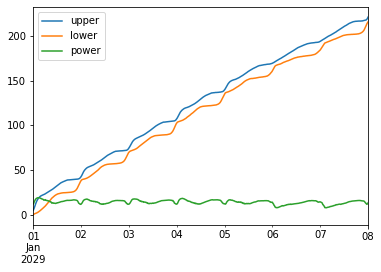

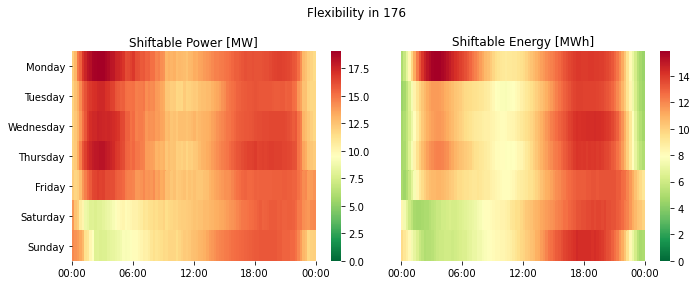

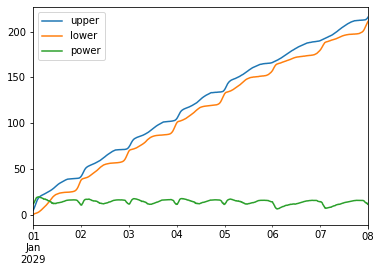

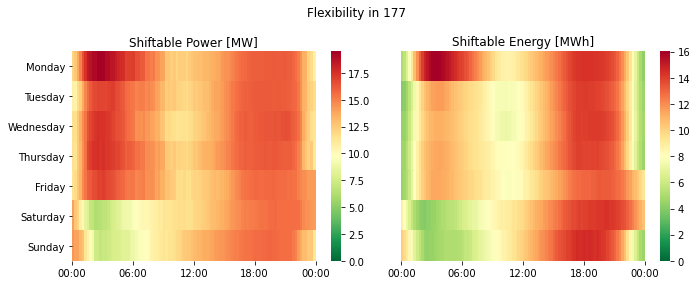

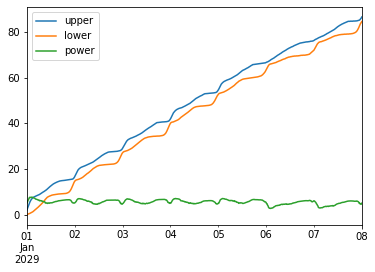

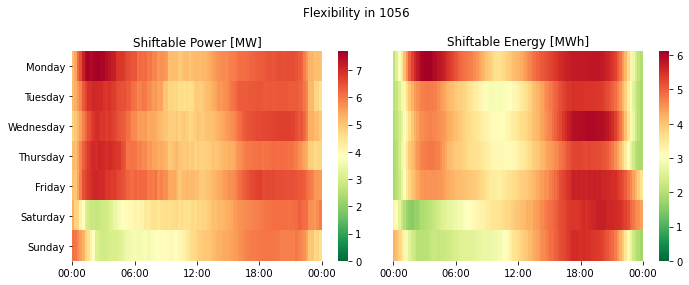

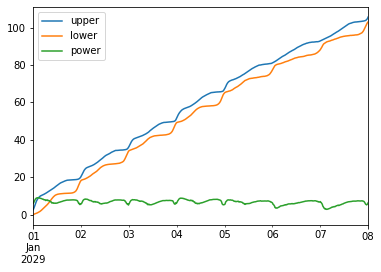

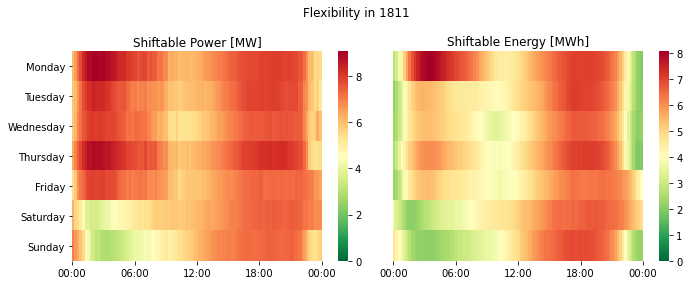

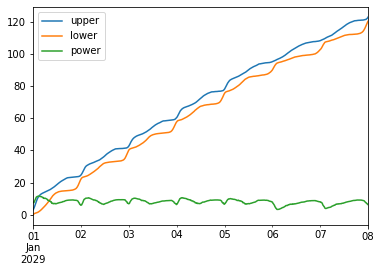

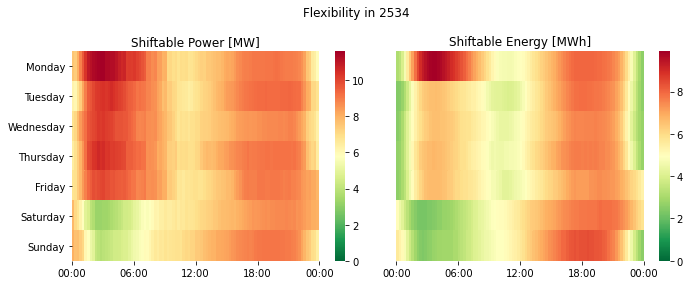

In [44]:
grid_ids = [176, 177, 1056, 1811, 2534]
for grid_id in grid_ids:
    flexibility_bands_home = \
        pd.read_csv('grid_data/ev_flexibility_bands_{}_home.csv'.format(grid_id), index_col=0,
                    dtype=np.float16)
    flexibility_bands_work = \
        pd.read_csv('grid_data/ev_flexibility_bands_{}_work.csv'.format(grid_id), index_col=0,
                    dtype=np.float16)
    flexibility_bands = pd.concat([flexibility_bands_work, flexibility_bands_home],
                                  axis=1)
    flexibility_bands = \
        flexibility_bands.groupby(flexibility_bands.columns, axis=1).sum()
    timeindex = pd.date_range('2029-01-01', '2029-01-08', freq='15min')
    bands = flexibility_bands.set_index(timeindex)
    columns_upper = [col for col in bands.columns if 'upper' in col]
    columns_lower = [col for col in bands.columns if 'lower' in col]
    columns_power = [col for col in bands.columns if 'power' in col]
    aggregated_bands = pd.DataFrame()
    aggregated_bands['upper'] = bands[columns_upper].sum(axis=1)
    aggregated_bands['lower'] = bands[columns_lower].sum(axis=1)
    aggregated_bands['power'] = bands[columns_power].sum(axis=1)
    aggregated_bands.plot()
    df_power = aggregated_bands['power'].iloc[:-1]
    df_energy = (aggregated_bands['upper'].iloc[:-1] - aggregated_bands['lower'].iloc[:-1])
    plot_hm_quarterly(df_power, df_energy, title='Flexibility in {}'.format(grid_id), 
                      filename='results/plots/flexibility_potential_{}.pdf'.format(grid_id))

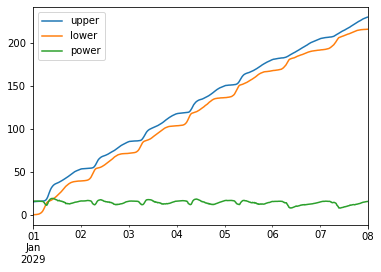

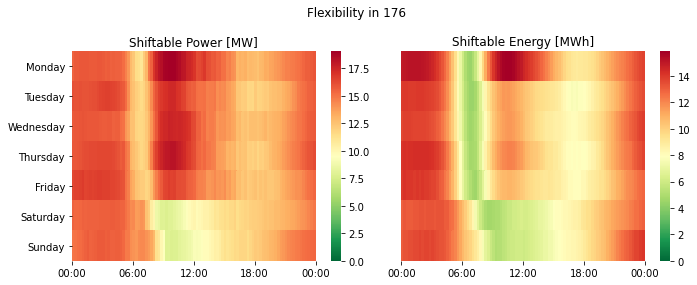

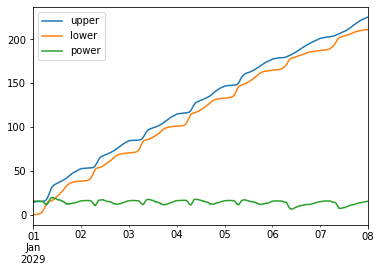

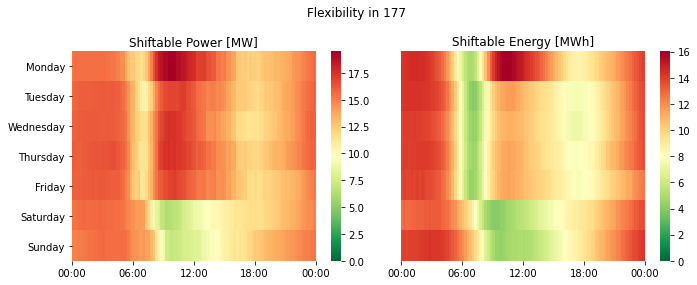

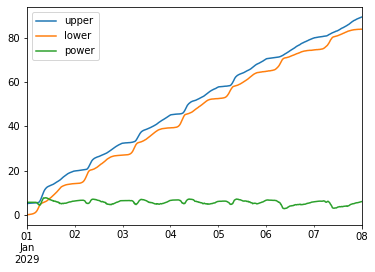

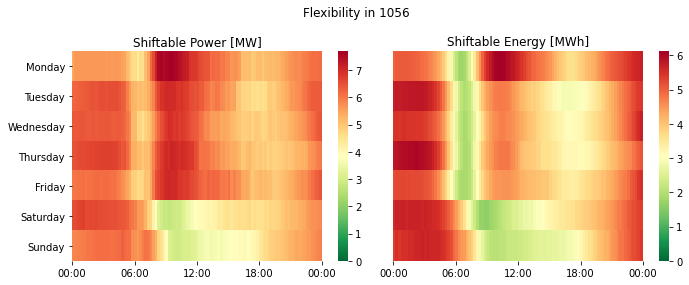

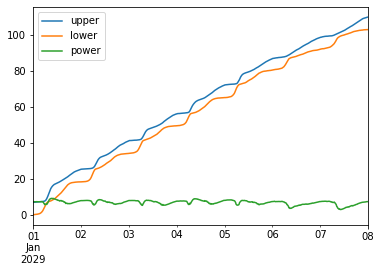

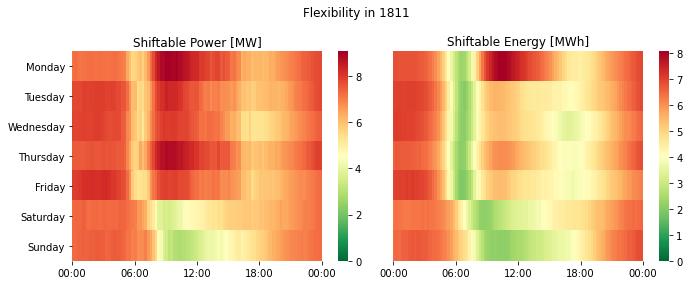

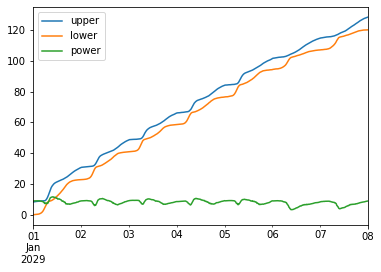

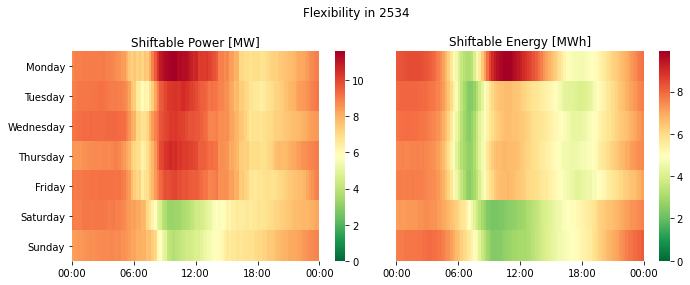

In [45]:
grid_ids = [176, 177, 1056, 1811, 2534]
for grid_id in grid_ids:
    flexibility_bands_home_00 = \
        pd.read_csv('grid_data/flex_bands_00_00/ev_flexibility_bands_{}_home.csv'.format(grid_id), index_col=0,
                    dtype=np.float16)
    flexibility_bands_work_00 = \
        pd.read_csv('grid_data/flex_bands_00_00/ev_flexibility_bands_{}_work.csv'.format(grid_id), index_col=0,
                    dtype=np.float16)
    flexibility_bands_00 = pd.concat([flexibility_bands_work_00, flexibility_bands_home_00],
                                  axis=1)
    flexibility_bands_00 = \
        flexibility_bands_00.groupby(flexibility_bands_00.columns, axis=1).sum()
    timeindex = pd.date_range('2029-01-01', '2029-01-08', freq='15min')
    bands_00 = flexibility_bands_00.set_index(timeindex)
    columns_upper = [col for col in bands_00.columns if 'upper' in col]
    columns_lower = [col for col in bands_00.columns if 'lower' in col]
    columns_power = [col for col in bands_00.columns if 'power' in col]
    aggregated_bands_00 = pd.DataFrame()
    aggregated_bands_00['upper'] = bands_00[columns_upper].sum(axis=1)
    aggregated_bands_00['lower'] = bands_00[columns_lower].sum(axis=1)
    aggregated_bands_00['power'] = bands_00[columns_power].sum(axis=1)
    aggregated_bands_00.plot()
    df_power_00 = aggregated_bands_00['power'].iloc[:-1]
    df_energy_00 = (aggregated_bands_00['upper'].iloc[:-1] - aggregated_bands_00['lower'].iloc[:-1])
    plot_hm_quarterly(df_power, df_energy, title='Flexibility in {}'.format(grid_id), 
                      filename='results/plots/flexibility_potential_{}.pdf'.format(grid_id))

In [53]:
df_power = aggregated_bands['power'].iloc[:-1]
df_energy = (aggregated_bands['upper'].iloc[:-1] - aggregated_bands['lower'].iloc[:-1])
df_power_00 = aggregated_bands_00['power'].iloc[:-1]
df_energy_00 = (aggregated_bands_00['upper'].iloc[:-1] - aggregated_bands_00['lower'].iloc[:-1])

<AxesSubplot:>

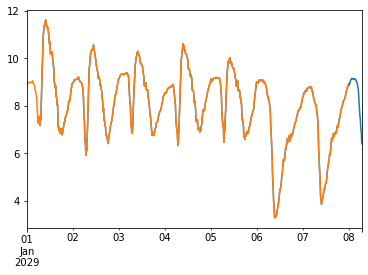

In [63]:
df_power_tmp = df_power
df_power_tmp.index = pd.date_range('2029-01-01 7:00', '2029-01-08 6:45', freq='15min')
df_power_tmp.plot()
df_power_00.plot()

<AxesSubplot:>

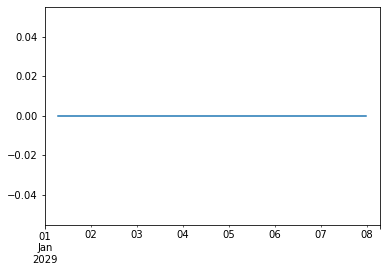

In [74]:
(df_power_00-df_power_tmp).plot()

<AxesSubplot:>

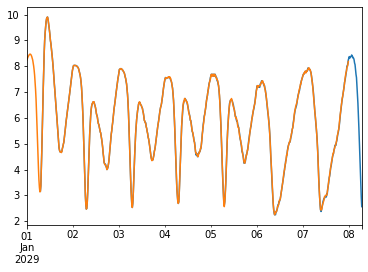

In [75]:
df_energy_tmp = df_energy
df_energy_tmp.index = pd.date_range('2029-01-01 7:00', '2029-01-08 6:45', freq='15min')
df_energy_tmp.plot()
df_energy_00.plot()

<AxesSubplot:>

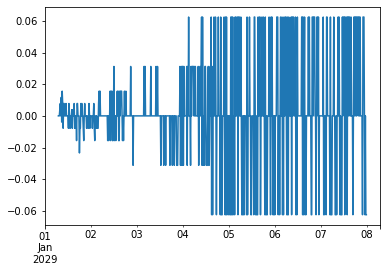

In [76]:
(df_energy_00-df_energy_tmp).plot()

In [82]:
np.nan_to_num((df_energy_00-df_energy_tmp).values).sum()

0.9883

In [62]:
df_power_tmp = df_power

In [52]:
bands.loc[pd.to_datetime('2029-01-01')]-bands_00.loc[pd.to_datetime('2029-01-01 7:15')]

lower_9184119_0      -0.065247
lower_9184119_1      -0.003719
lower_9184119_10     -0.016632
lower_9184119_100    -0.005501
lower_9184119_1000   -0.001850
lower_9184119_1002    0.000000
lower_9184119_1005    0.000000
lower_9184119_1009    0.000000
lower_9184119_101    -0.005630
lower_9184119_1010    0.000000
lower_9184119_1012   -0.008247
lower_9184119_1019   -0.005501
lower_9184119_102    -0.016495
lower_9184119_1024    0.000000
lower_9184119_1027    0.000000
lower_9184119_103     0.000000
lower_9184119_1031    0.000000
lower_9184119_1036   -0.005501
lower_9184119_104    -0.005501
lower_9184119_1041    0.000000
lower_9184119_1049   -0.027496
lower_9184119_105    -0.040497
lower_9184119_1050   -0.002750
lower_9184119_1051   -0.013878
lower_9184119_1052   -0.008247
lower_9184119_1053   -0.002750
lower_9184119_1054    0.000000
lower_9184119_1057    0.000000
lower_9184119_106    -0.008278
lower_9184119_1061    0.000000
                        ...   
upper_9184119_916    -0.019257
upper_91

In [20]:
bands

,lower_8325011_0,lower_8325011_1,lower_8325011_10,lower_8325011_100,lower_8325011_1004,lower_8325011_1006,lower_8325011_1008,lower_8325011_101,lower_8325011_102,lower_8325011_1022,...,upper_8325069_977,upper_8325069_98,upper_8325069_981,upper_8325069_985,upper_8325069_988,upper_8325069_989,upper_8325069_99,upper_8325069_990,upper_8325069_994,upper_8325069_999
2029-01-01 07:00:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.008247,0.005501,0.000000,0.011101,0.005501,0.000000,0.0000,0.000000,0.000000,0.000000
2029-01-01 07:15:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.008247,0.005501,0.000000,0.011101,0.005501,0.000000,0.0000,0.000000,0.000000,0.000000
2029-01-01 07:30:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.008247,0.005501,0.000000,0.011101,0.005501,0.000000,0.0000,0.000000,0.000000,0.002745
2029-01-01 07:45:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.008247,0.005501,0.000000,0.011101,0.005501,0.000000,0.0000,0.000000,0.000000,0.005489
2029-01-01 08:00:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.008247,0.005501,0.000000,0.011101,0.005501,0.000000,0.0000,0.000000,0.000000,0.008232
2029-01-01 08:15:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.008247,0.005501,0.000000,0.011101,0.005501,0.000000,0.0000,0.000000,0.000000,0.010979
2029-01-01 08:30:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.008247,0.005501,0.000000,0.011101,0.005501,0.000000,0.0000,0.000000,0.000000,0.013725
2029-01-01 08:45:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.008247,0.005501,0.000000,0.011101,0.005501,0.000000,0.0000,0.000000,0.000000,0.016464
2029-01-01 09:00:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.008247,0.005501,0.000000,0.011101,0.005501,0.000000,0.0000,0.000000,0.000000,0.019211
2029-01-01 09:15:00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.008247,0.005501,0.000000,0.011101,0.005501,0.000000,0.0000,0.000000,0.000000,0.019257


In [19]:
pd.concat([bands.iloc[7*4:], bands.iloc[:7*4]])

,lower_8325011_0,lower_8325011_1,lower_8325011_10,lower_8325011_100,lower_8325011_1004,lower_8325011_1006,lower_8325011_1008,lower_8325011_101,lower_8325011_102,lower_8325011_1022,...,upper_8325069_977,upper_8325069_98,upper_8325069_981,upper_8325069_985,upper_8325069_988,upper_8325069_989,upper_8325069_99,upper_8325069_990,upper_8325069_994,upper_8325069_999
2029-01-01 14:00:00,0.010117,0.000000,0.033112,0.002810,0.000000,0.000000,0.000000,0.00000,0.012878,0.005516,...,0.008247,0.008247,0.000000,0.011101,0.005501,0.000000,0.000000,0.000000,0.000000,0.019257
2029-01-01 14:15:00,0.011032,0.000000,0.034027,0.005554,0.000000,0.000000,0.000000,0.00000,0.012878,0.008263,...,0.008247,0.010986,0.000000,0.011101,0.005501,0.000000,0.000000,0.000000,0.000000,0.019257
2029-01-01 14:30:00,0.011963,0.000000,0.034027,0.008301,0.000000,0.000000,0.000000,0.00000,0.012878,0.011002,...,0.008247,0.013733,0.000000,0.011101,0.005501,0.000000,0.000000,0.000000,0.000000,0.019257
2029-01-01 14:45:00,0.012878,0.000000,0.034027,0.011047,0.000000,0.000000,0.000000,0.00000,0.012878,0.013748,...,0.008247,0.016479,0.000000,0.011101,0.005501,0.000000,0.005489,0.000000,0.000000,0.019257
2029-01-01 15:00:00,0.013802,0.002745,0.034027,0.013794,0.000000,0.000000,0.000000,0.00000,0.012878,0.013748,...,0.008247,0.016510,0.000000,0.011101,0.005501,0.000000,0.010979,0.000000,0.000000,0.019257
2029-01-01 15:15:00,0.014725,0.005489,0.034027,0.016541,0.000000,0.000000,0.000000,0.00000,0.012878,0.013748,...,0.008247,0.016510,0.000000,0.011101,0.005501,0.000000,0.016464,0.000000,0.000000,0.019257
2029-01-01 15:30:00,0.015656,0.005489,0.034027,0.019287,0.000000,0.000000,0.000000,0.00000,0.012878,0.013748,...,0.008247,0.016510,0.000000,0.011101,0.005501,0.000000,0.016495,0.000000,0.000000,0.019257
2029-01-01 15:45:00,0.016632,0.005489,0.034027,0.022034,0.000000,0.000000,0.000000,0.00000,0.012878,0.013748,...,0.008247,0.019257,0.000000,0.011101,0.005501,0.000000,0.016495,0.000000,0.002745,0.019257
2029-01-01 16:00:00,0.018463,0.005489,0.034027,0.022034,0.000000,0.000000,0.000000,0.00000,0.012939,0.013748,...,0.008247,0.019257,0.000000,0.011101,0.005501,0.000000,0.016495,0.000000,0.002750,0.019257
2029-01-01 16:15:00,0.020325,0.005489,0.034027,0.022034,0.000000,0.000000,0.000000,0.00000,0.015686,0.013748,...,0.008247,0.019257,0.000000,0.011101,0.005501,0.000000,0.016495,0.000000,0.002750,0.019257


In [6]:
use_case = 'home'
flexibility_bands = pd.read_csv('grid_data/ev_flexibility_bands_{}.csv'.format(use_case), index_col=0)
timeindex = pd.date_range('2029-01-01', '2029-01-08', freq='15min')
bands = flexibility_bands.iloc[0:673].set_index(timeindex)
bands.head()

,upper_9471133_0,lower_9471133_0,power_9471133_0,upper_9674130_0,lower_9674130_0,power_9674130_0,upper_9674184_0,lower_9674184_0,power_9674184_0,upper_9674190_0,...,power_9674210_390,upper_9674190_413,lower_9674190_413,power_9674190_413,upper_9674210_482,lower_9674210_482,power_9674210_482,upper_9674210_486,lower_9674210_486,power_9674210_486
2029-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\Anya.Heider\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:4015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


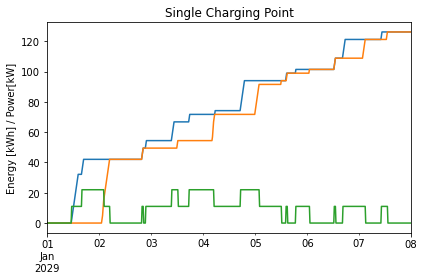

In [23]:
tmp_bands = bands.iloc[:, 0:3]
tmp_bands.rename(columns={col:col.split('_')[0] for col in tmp_bands.columns}, inplace=True)
ax = tmp_bands.plot(legend=False)
plt.ylabel('Energy [kWh] / Power[kW]')
plt.title('Single Charging Point')
plt.tight_layout()
plt.savefig('plots/energy_bands_single_cp.pdf')

In [13]:
columns_upper = [col for col in bands.columns if 'upper' in col]
columns_lower = [col for col in bands.columns if 'lower' in col]
columns_power = [col for col in bands.columns if 'power' in col]

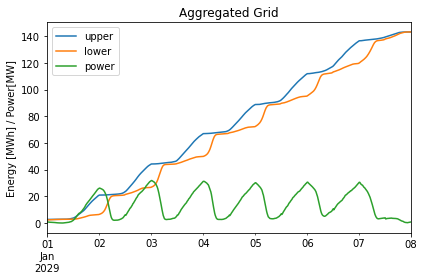

In [24]:
aggregated_bands = pd.DataFrame()
aggregated_bands['upper'] = bands[columns_upper].sum(axis=1)
aggregated_bands['lower'] = bands[columns_lower].sum(axis=1)
aggregated_bands['power'] = bands[columns_power].sum(axis=1)
(aggregated_bands/1e3).plot()
plt.ylabel('Energy [MWh] / Power[MW]')
plt.title('Aggregated Grid')
plt.tight_layout()
plt.savefig('plots/energy_bands_grid.pdf')

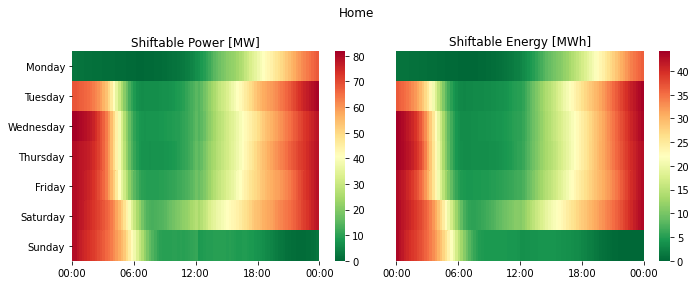

In [14]:
df_power = aggregated_bands['power'].iloc[:-1]/1e3
df_energy = (aggregated_bands['upper'].iloc[:-1] - aggregated_bands['lower'].iloc[:-1])/1e3
filename = 'plots/{}.pdf'.format(use_case)
plot_hm_quarterly(df_power, df_energy, title=use_case.capitalize())

In [15]:
use_case = 'work'
flexibility_bands = pd.read_csv('grid_data/ev_flexibility_bands_{}.csv'.format(use_case), index_col=0)
timeindex = pd.date_range('2029-01-01', '2029-01-08', freq='15min')
bands = flexibility_bands.iloc[0:673].set_index(timeindex)
bands.head()

,upper_8325011_0,lower_8325011_0,power_8325011_0,upper_8325049_0,lower_8325049_0,power_8325049_0,upper_8325060_0,lower_8325060_0,power_8325060_0,upper_8325069_0,...,power_8325049_1124,upper_8325049_1126,lower_8325049_1126,power_8325049_1126,upper_8325049_1128,lower_8325049_1128,power_8325049_1128,upper_8325049_1130,lower_8325049_1130,power_8325049_1130
2029-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,14.85,12.375,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,14.85,14.850,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,14.85,14.850,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,14.85,14.850,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,14.85,14.850,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
columns_upper = [col for col in bands.columns if 'upper' in col]
columns_lower = [col for col in bands.columns if 'lower' in col]
columns_power = [col for col in bands.columns if 'power' in col]

<AxesSubplot:>

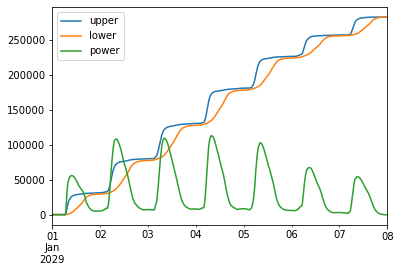

In [17]:
aggregated_bands = pd.DataFrame()
aggregated_bands['upper'] = bands[columns_upper].sum(axis=1)
aggregated_bands['lower'] = bands[columns_lower].sum(axis=1)
aggregated_bands['power'] = bands[columns_power].sum(axis=1)
aggregated_bands.plot()

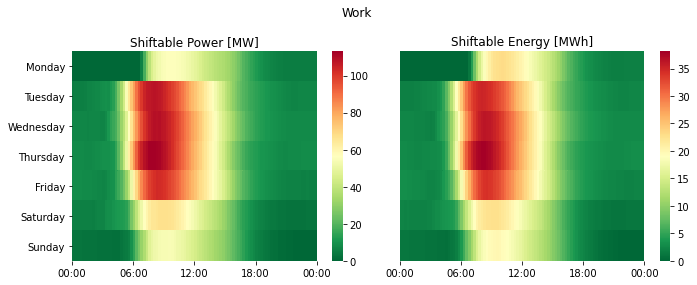

In [18]:
df_power = aggregated_bands['power'].iloc[:-1]/1e3
df_energy = (aggregated_bands['upper'].iloc[:-1] - aggregated_bands['lower'].iloc[:-1])/1e3
plot_hm_quarterly(df_power, df_energy, title=use_case.capitalize())

# Optimise operation of flexibility options

In [83]:
grid_id = 1056

In [94]:
downstream_node_matrix = pd.read_csv('grid_data/downstream_node_matrix_{}.csv'.format(grid_id))

In [95]:
len(downstream_node_matrix)

383

In [84]:
root_dir = r'U:\Software'
mapping_dir = root_dir + r'\simbev_nep_2035_results\eDisGo_charging_time_series\{}'.format(grid_id)
edisgo_dir = root_dir + r'\eDisGo_object_files\simbev_nep_2\{}\reduced'.format(grid_id)
result_dir = 'results/{}'.format(grid_id)

In [85]:
edisgo_obj = import_edisgo_from_files(edisgo_dir, import_timeseries=True)

U:\Software\eDisGo_mirror\edisgo\tools\plots.py:593: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ][edisgo_obj.topology.lines_df.bus1.isin(pypsa_plot.buses.index)].loc[


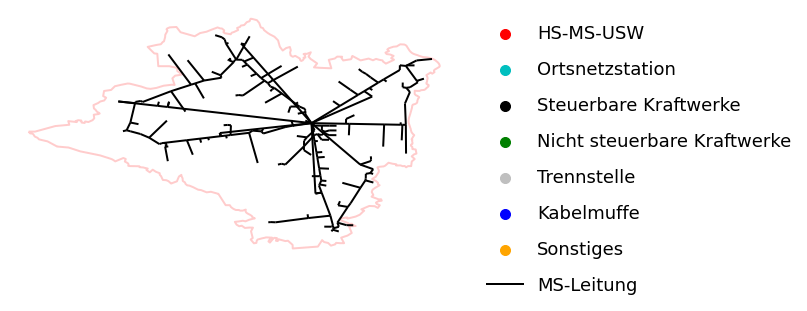

In [87]:
edisgo_obj.plot_mv_grid_topology()

In [89]:
pypsa_network = edisgo_obj.to_pypsa()

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [90]:
edisgo_obj.analyze()

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-01-08 07:00:00', '2011-01-08 07:15:00',
               '2011-01-08 07:30:00', '2011-01-08 07:45:00',
               '2011-01-08 08:00:00', '2011-01-08 08:15:00',
               '2011-01-08 08:30:00', '2011-01-08 08:45:00',
               '2011-01-08 09:00:00', '2011-01-08 09:15:00',
               ...
               '2011-05-07 04:30:00', '2011-05-07 04:45:00',
               '2011-05-07 05:00:00', '2011-05-07 05:15:00',
               '2011-05-07 05:30:00', '2011-05-07 05:45:00',
               '2011-05-07 06:00:00', '2011-05-07 06:15:00',
               '2011-05-07 06:30:00', '2011-05-07 06:45:00'],
              dtype='datetime64[ns]', length=1344, freq=None)
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-08 07:00:00', '2011-01-08 07:15:00',
               '2011-01-08 07:30:00', '2011-01-08 07:45:00',
      

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.267009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.281512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.260009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.289510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.286505 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.290513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.280004 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.292714 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.263003 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.299013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.288511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.292510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.288508 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.287513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.306010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.290005 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.307516 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.313495 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.284006 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.291507 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.323512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.331512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.284513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.303010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.278011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.288011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.359512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.388017 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.329504 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.285512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.303013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.298512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.294007 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.278009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.353014 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.308006 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.289013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.304009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.296023 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.318510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.291513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.321009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.294009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.278012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.308012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.302010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.346518 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.283514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.313898 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.296009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.289507 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.290009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.276013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.313504 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.313008 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.278012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.287513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.274508 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.285009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.319511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.303504 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.293508 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.283516 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.312503 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.268512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.269001 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.268008 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.282009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.267008 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.269006 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.295011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.297510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.302515 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.284509 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.278517 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.308015 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.290509 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.351507 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.359517 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.294509 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.281012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.284692 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.294514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.271507 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.288509 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.294010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.289513 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.288008 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.292444 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.296510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.276012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.276012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.269012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.278511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.297509 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.288505 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.276508 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.286507 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.309514 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.291996 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.297508 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.310006 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.354335 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.272505 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.274503 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.281510 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.285501 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.351007 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.298509 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.299007 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.336012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.342007 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.326007 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.288002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.313006 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.364009 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.370508 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.346505 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.297511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.337001 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.312013 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.300505 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.310008 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.320010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.289976 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.287500 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.331509 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.291512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.287007 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.309521 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.331011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.293507 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.277507 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.309005 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.278512 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.329010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.313509 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.309518 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.287506 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.287007 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.296500 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.287010 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.277346 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.285509 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.268011 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.313511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.290012 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.277004 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.274511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.310511 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

In [10]:
flexibility_bands_home = \
    pd.read_csv('grid_data/ev_flexibility_bands_home.csv', index_col=0)
flexibility_bands_work = \
    pd.read_csv('grid_data/ev_flexibility_bands_work.csv', index_col=0)
flexibility_bands = pd.concat([flexibility_bands_work, flexibility_bands_home],
                              axis=1)
mapping_home = \
    gpd.read_file(cp_mapping_dir + '\cp_data_home_within_grid_{}.geojson'.
                  format(grid_id)).set_index('edisgo_id')
mapping_work = \
    gpd.read_file(cp_mapping_dir + '\cp_data_work_within_grid_{}.geojson'.
                  format(grid_id)).set_index('edisgo_id')
mapping = pd.concat([mapping_work, mapping_home])

c:\users\anya.heider\appdata\local\continuum\miniconda3\envs\edisgo_env\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [11]:
len(mapping), len(flexibility_bands.columns)

(3461, 10383)

In [13]:
check_mapping(mapping, edisgo_obj, flexibility_bands)

In [16]:
downstream_node_matrix = pd.read_csv('grid_data/downstream_node_matrix.csv', index_col=0)

In [1]:
timesteps= pd.date_range('2029-01-01 7:00', '2029-01-08', freq='15min')
flexibility_bands = flexibility_bands.iloc[:len(timesteps)].set_index(timesteps)
model = setup_model(edisgo_obj, downstream_node_matrix, timesteps, optimize_storage=False,
                        mapping_cp=mapping, energy_band_charging_points=flexibility_bands)

NameError: name 'pd' is not defined

# Comparison with ACPF results

In [2]:
from edisgo.edisgo import import_edisgo_from_files
from edisgo.flex_opt.optimization import setup_model, optimize, check_mapping
from edisgo.tools.tools import convert_impedances_to_mv

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning:

Ignoring declarative-like tuple value of attribute 'segment': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning:

Ignoring declarative-like tuple value of attribute 'cable': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?



In [3]:
import pandas as pd
import numpy as np

In [4]:
grid_id = 2534
feeder_id = 0
root_dir = r'U:\Software'
edisgo_dir = root_dir + r'\eDisGo_object_files\simbev_nep_2035_results\{}\feeder\{}'.format(grid_id, feeder_id)


In [5]:
edisgo_orig = import_edisgo_from_files(edisgo_dir, import_timeseries=True)
edisgo_obj = convert_impedances_to_mv(edisgo_orig)


In [187]:
grid_id

1056

In [7]:
len(edisgo_obj.topology.buses_df)

90

In [183]:
timesteps = edisgo_obj.timeseries.timeindex[0:96]

In [184]:
try:
    downstream_nodes_matrix = pd.read_csv(
        'grid_data/feeder_data/downstream_node_matrix_{}_{}.csv'.format(grid_id, feeder_id),
        index_col=0)
except:
    downstream_nodes_matrix = get_downstream_nodes_matrix_iterative(edisgo_obj.topology)
    #downstream_nodes_matrix.to_csv('grid_data/downstream_node_matrix_{}.csv'.format(grid_id))

downstream_nodes_matrix = downstream_nodes_matrix.astype(np.uint8)
downstream_nodes_matrix = downstream_nodes_matrix.loc[
        edisgo_obj.topology.buses_df.index,
        edisgo_obj.topology.buses_df.index]

In [193]:
objective='residual_load'
model = setup_model(edisgo_obj, downstream_nodes_matrix, timesteps, objective=objective,
                            optimize_storage=False, optimize_ev_charging=False,
                            pu=False, v_min=0, v_max=2)

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.
Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.


In [194]:
(model.nodal_reactive_feedin<0).any().any()

False

In [195]:
edisgo_obj.timeseries._generators_reactive_power

,Generator_mvgd_1056_solar_ground_mounted_750114,Generator_mvgd_1056_wind_onshore_752950,Generator_mvgd_1056_lvgd_97101_solar_roof_mounted_749943,Generator_mvgd_1056_lvgd_97101_solar_roof_mounted_750013,Generator_mvgd_1056_lvgd_97101_solar_roof_mounted_750017,Generator_mvgd_1056_lvgd_97101_solar_roof_mounted_750056,Generator_mvgd_1056_lvgd_97101_solar_roof_mounted_750261,Generator_mvgd_1056_lvgd_97101_solar_roof_mounted_752141,Generator_mvgd_1056_lvgd_97101_solar_roof_mounted_752481,Generator_mvgd_1056_lvgd_97101_solar_roof_mounted_752953,...,Generator_solar_LVGrid_102248_3964212,Generator_solar_LVGrid_97221_3964213,Generator_solar_LVGrid_102785_3964214,Generator_solar_LVGrid_99310_3964220,Generator_solar_LVGrid_102242_3964223,Generator_solar_LVGrid_99308_3964225,Generator_solar_LVGrid_102937_3964227,Generator_solar_LVGrid_103068_3964233,Generator_solar_LVGrid_502473_3964239,Generator_solar_LVGrid_97341_3964240
2011-01-08 07:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-08 07:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-08 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-08 07:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-08 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-08 08:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-08 08:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-08 08:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-08 09:00:00,0.001734,0.000000,0.000011,0.000040,0.000020,3.755093e-06,6.139278e-06,2.384186e-06,0.000010,8.344650e-07,...,0.000019,0.000019,0.000013,0.000019,0.000019,0.000019,0.000013,0.000013,0.000013,0.000019
2011-01-08 09:15:00,0.001734,0.000000,0.000011,0.000040,0.000020,3.755093e-06,6.139278e-06,2.384186e-06,0.000010,8.344650e-07,...,0.000019,0.000019,0.000013,0.000019,0.000019,0.000019,0.000013,0.000013,0.000013,0.000019


In [196]:
x_charge, soc, charging_ev, energy_level, curtailment_feedin, \
    curtailment_load, curtailment_reactive_feedin, curtailment_reactive_load, \
    v_bus, p_line, q_line, slack_charging, slack_energy, slack_v_pos,\
    slack_v_neg, slack_p_cum_pos, slack_p_cum_neg = optimize(model, 'gurobi')

Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmp_wl24fsp.pyomo.lp
Reading time = 32.21 seconds
x2465473: 1792993 rows, 2465473 columns, 27525601 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 1792993 rows, 2465473 columns and 27525601 nonzeros
Model fingerprint: 0xf6c3a20e
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [9e-05, 1e+02]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [8e-07, 1e-01]
  RHS range        [5e-07, 4e+02]
Presolve removed 1160421 rows and 1470000 columns (presolve time = 5s) ...
Presolve removed 1277764 rows and 1795849 columns (presolve time = 10s) ...
Presolve removed 1277764 rows and 1795849 columns
Presolve time: 10.45s
Presolved: 515229 rows, 669624 columns, 5787116 nonzeros
Ordering time: 0.26s

Barrier statistics:
 Free vars  : 68437


In [197]:
v_bus.min().min(), v_bus.max().max()

(9.504378580903659, 10.0)

In [198]:
edisgo_obj.timeseries._generators_reactive_power = -edisgo_obj.timeseries._generators_reactive_power

In [199]:
objective='residual_load'
model = setup_model(edisgo_obj, downstream_nodes_matrix, timesteps, objective=objective,
                            optimize_storage=False, optimize_ev_charging=False,
                            pu=False, v_min=0, v_max=2)

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.
Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.


In [200]:
x_charge, soc, charging_ev, energy_level, curtailment_feedin, \
    curtailment_load, curtailment_reactive_feedin, curtailment_reactive_load, \
    v_bus, p_line, q_line, slack_charging, slack_energy, slack_v_pos,\
    slack_v_neg, slack_p_cum_pos, slack_p_cum_neg = optimize(model, 'gurobi')

Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmpkzcxy561.pyomo.lp
Reading time = 33.93 seconds
x2465473: 1792993 rows, 2465473 columns, 27525601 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 1792993 rows, 2465473 columns and 27525601 nonzeros
Model fingerprint: 0xeb2dd30e
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [9e-05, 1e+02]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [8e-07, 1e-01]
  RHS range        [4e-07, 4e+02]
Presolve removed 710421 rows and 1020000 columns (presolve time = 6s) ...
Presolve removed 1277696 rows and 1794501 columns (presolve time = 11s) ...
Presolve removed 1277764 rows and 1795849 columns
Presolve time: 13.94s
Presolved: 515229 rows, 669624 columns, 5787116 nonzeros
Ordering time: 0.30s

Barrier statistics:
 Free vars  : 68437
 

In [201]:
v_bus.min().min(), v_bus.max().max()

(9.504424035135214, 10.062526470807398)

In [93]:
curtailment_reactive_feedin.sum().sum()

1.3438000226368904e-10

In [22]:
edisgo_orig = import_edisgo_from_files(edisgo_dir, import_timeseries=True)
edisgo_orig.analyze(timesteps=timesteps)

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-04-16 07:00:00', '2011-04-16 07:15:00',
               '2011-04-16 07:30:00', '2011-04-16 07:45:00',
               '2011-04-16 08:00:00', '2011-04-16 08:15:00',
               '2011-04-16 08:30:00', '2011-04-16 08:45:00',
               '2011-04-16 09:00:00', '2011-04-16 09:15:00',
               '2011-04-16 09:30:00', '2011-04-16 09:45:00',
               '2011-04-16 10:00:00', '2011-04-16 10:15:00',
               '2011-04-16 10:30:00', '2011-04-16 10:45:00',
               '2011-04-16 11:00:00', '2011-04-16 11:15:00',
               '2011-04-16 11:30:00', '2011-04-16 11:45:00',
               '2011-04-16 12:00:00', '2011-04-16 12:15:00',
               '2011-04-16 12:30:00', '2011-04-16 12:45:00',
               '2011-04-16 13:00:00', '2011-04-16 13:15:00',
               '2011-04-16 13:30:00', '2011-04-16 13:45:00',
               '2011-04-16 14:00:00', '2011-04-16 14:15:0

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031308 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031243 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052985 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031250 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053023 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046877 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037356 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046878 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.037291 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046937 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

In [23]:
edisgo_orig.results.v_res.head()

name,BusBar_mvgd_2534_lvgd_20557_MV,BusBar_mvgd_2534_lvgd_20554_MV,BusBar_mvgd_2534_lvgd_20550_MV,BusBar_mvgd_2534_lvgd_449750_MV,BusBar_mvgd_2534_lvgd_20550_LV,BranchTee_mvgd_2534_lvgd_20550_1,BranchTee_mvgd_2534_lvgd_20550_2,Bus_mvgd_2534_lvgd_20550_loa_1,BranchTee_mvgd_2534_lvgd_20550_3,BranchTee_mvgd_2534_lvgd_20550_4,...,Bus_mvgd_2534_lvgd_20557_loa_10,BusBar_mvgd_2534_lvgd_449750_LV,BranchTee_mvgd_2534_lvgd_449750_1,BranchTee_mvgd_2534_lvgd_449750_2,Bus_mvgd_2534_lvgd_449750_loa_1,BranchTee_mvgd_2534_lvgd_449750_3,BranchTee_mvgd_2534_lvgd_449750_4,Bus_mvgd_2534_lvgd_449750_loa_2,Bus_Generator_3714315,Busbar_mvgd_2534_MV
2011-04-16 07:00:00,0.982700,0.977858,0.979335,0.991832,0.962263,0.910109,0.902287,0.902026,0.910109,0.902287,...,0.961968,0.987599,0.981400,0.981367,0.981365,0.975362,0.972885,0.972810,0.958297,1.0
2011-04-16 07:15:00,0.982764,0.977922,0.979399,0.991872,0.962328,0.910179,0.902357,0.902096,0.910179,0.902357,...,0.962101,0.988633,0.982441,0.982407,0.982406,0.976409,0.973935,0.973860,0.958364,1.0
2011-04-16 07:30:00,0.982760,0.977918,0.979395,0.991868,0.962324,0.910174,0.902353,0.902092,0.910174,0.902353,...,0.962097,0.988423,0.981836,0.981803,0.981801,0.975411,0.972775,0.972695,0.958360,1.0
2011-04-16 07:45:00,0.982760,0.977918,0.979395,0.991868,0.962324,0.910174,0.902353,0.902092,0.910174,0.902353,...,0.962097,0.988423,0.981836,0.981803,0.981801,0.975411,0.972775,0.972695,0.958360,1.0
2011-04-16 08:00:00,0.982960,0.978217,0.979656,0.991962,0.962590,0.910456,0.902637,0.902377,0.910456,0.902637,...,0.963647,0.988506,0.981907,0.981872,0.981870,0.975475,0.972837,0.972757,0.956204,1.0


In [94]:
v_bus_rel = v_bus/10

In [97]:
v_bus_rel.min().min(), edisgo_orig.results.v_res.loc[v_bus_rel.index, v_bus_rel.columns].min().min()

(0.9076583627947263, 0.9019962082679298)

In [95]:
v_diff=v_bus_rel-edisgo_orig.results.v_res.loc[v_bus_rel.index, v_bus_rel.columns]
v_diff.max().max(), v_diff.min().min()

(0.0057555982592066846, 0.0)

In [33]:
v_diff.loc[(v_diff==v_diff.max().max()).any(axis=1), (v_diff==v_diff.max().max()).any()]

,Bus_mvgd_2534_lvgd_20557_loa_2,Bus_mvgd_2534_lvgd_20557_loa_3,Bus_mvgd_2534_lvgd_20557_loa_4,Bus_mvgd_2534_lvgd_20557_loa_6
2011-04-16 07:00:00,0.211497,0.211497,0.211497,0.211497


In [34]:
v_bus_rel.loc[(v_diff==v_diff.max().max()).any(axis=1), (v_diff==v_diff.max().max()).any()]

,Bus_mvgd_2534_lvgd_20557_loa_2,Bus_mvgd_2534_lvgd_20557_loa_3,Bus_mvgd_2534_lvgd_20557_loa_4,Bus_mvgd_2534_lvgd_20557_loa_6
2011-04-16 07:00:00,1.134826,1.134826,1.134826,1.134826


In [35]:
edisgo_orig.results.v_res.loc[v_bus_rel.index, v_bus_rel.columns].loc[(v_diff==v_diff.max().max()).any(axis=1), (v_diff==v_diff.max().max()).any()]

,Bus_mvgd_2534_lvgd_20557_loa_2,Bus_mvgd_2534_lvgd_20557_loa_3,Bus_mvgd_2534_lvgd_20557_loa_4,Bus_mvgd_2534_lvgd_20557_loa_6
2011-04-16 07:00:00,0.923329,0.923329,0.923329,0.923329


In [36]:
(edisgo_orig.results.v_res.loc[v_bus_rel.index, v_bus_rel.columns]>1.0).any().any()

False

In [40]:
(v_bus_rel<1.0).sum().sum(), (v_bus_rel>1.0).sum().sum()

(2304, 6240)

In [45]:
model.nodal_active_power.head()

,2011-04-16 07:00:00,2011-04-16 07:15:00,2011-04-16 07:30:00,2011-04-16 07:45:00,2011-04-16 08:00:00,2011-04-16 08:15:00,2011-04-16 08:30:00,2011-04-16 08:45:00,2011-04-16 09:00:00,2011-04-16 09:15:00,...,2011-12-10 04:30:00,2011-12-10 04:45:00,2011-12-10 05:00:00,2011-12-10 05:15:00,2011-12-10 05:30:00,2011-12-10 05:45:00,2011-12-10 06:00:00,2011-12-10 06:15:00,2011-12-10 06:30:00,2011-12-10 06:45:00
name,,,,,,,,,,,,,,,,,,,,,
BusBar_mvgd_2534_lvgd_20557_MV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BusBar_mvgd_2534_lvgd_20554_MV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BusBar_mvgd_2534_lvgd_20550_MV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BusBar_mvgd_2534_lvgd_449750_MV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BusBar_mvgd_2534_lvgd_20550_LV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
model.nodal_active_power.loc[(v_diff==v_diff.max().max()).any(), v_diff.index[(v_diff==v_diff.max().max()).any(axis=1)]]

,2011-04-16 07:00:00
name,
Bus_mvgd_2534_lvgd_20557_loa_2,-0.245728
Bus_mvgd_2534_lvgd_20557_loa_3,-0.245728
Bus_mvgd_2534_lvgd_20557_loa_4,-0.245728
Bus_mvgd_2534_lvgd_20557_loa_6,-0.245728


In [53]:
edisgo_orig.timeseries.loads_active_power.loc[:, edisgo_orig.topology.loads_df.loc[edisgo_orig.topology.loads_df.bus=='Bus_mvgd_2534_lvgd_20557_loa_2'].index].head()

name,Loads_Bus_mvgd_2534_lvgd_20557_loa_2
2011-04-16 07:00:00,0.245728
2011-04-16 07:15:00,0.245728
2011-04-16 07:30:00,0.245728
2011-04-16 07:45:00,0.245728
2011-04-16 08:00:00,0.245728


In [51]:
edisgo_orig.topology.lines_df.loc[edisgo_orig.topology.lines_df.bus1=='Bus_mvgd_2534_lvgd_20557_loa_2']

,bus0,bus1,kind,length,num_parallel,r,s_nom,type_info,x
name,,,,,,,,,
Branch_LVCableDist_mvgd_2534_lvgd_20557_4_Load_mvgd_2534_lvgd_20557_2,BranchTee_mvgd_2534_lvgd_20557_4,Bus_mvgd_2534_lvgd_20557_loa_2,cable,0.001,1.0,0.000077,0.377379,NAYY 4x1x300,0.000067


In [54]:
v_bus_rel.loc[:,'BranchTee_mvgd_2534_lvgd_20557_4'].head()

2011-04-16 07:00:00    1.134960
2011-04-16 07:15:00    1.133523
2011-04-16 07:30:00    1.133519
2011-04-16 07:45:00    1.133519
2011-04-16 08:00:00    1.131430
Name: BranchTee_mvgd_2534_lvgd_20557_4, dtype: float64

In [55]:
v_bus_rel.iloc[0]

BusBar_mvgd_2534_lvgd_20557_MV         0.984365
BusBar_mvgd_2534_lvgd_20554_MV         0.979950
BusBar_mvgd_2534_lvgd_20550_MV         0.981299
BusBar_mvgd_2534_lvgd_449750_MV        0.992651
BusBar_mvgd_2534_lvgd_20550_LV         0.965675
BranchTee_mvgd_2534_lvgd_20550_1       0.915671
BranchTee_mvgd_2534_lvgd_20550_2       0.907933
Bus_mvgd_2534_lvgd_20550_loa_1         0.907674
BranchTee_mvgd_2534_lvgd_20550_3       0.915671
BranchTee_mvgd_2534_lvgd_20550_4       0.907933
Bus_mvgd_2534_lvgd_20550_loa_2         0.907674
BranchTee_mvgd_2534_lvgd_20550_5       0.915671
BranchTee_mvgd_2534_lvgd_20550_6       0.907933
Bus_mvgd_2534_lvgd_20550_loa_3         0.907674
BranchTee_mvgd_2534_lvgd_20550_7       0.915671
BranchTee_mvgd_2534_lvgd_20550_8       0.907933
Bus_mvgd_2534_lvgd_20550_loa_4         0.907674
BusBar_mvgd_2534_lvgd_20554_LV         1.136093
Bus_mvgd_2534_lvgd_20554_gen_507436    1.136097
Bus_mvgd_2534_lvgd_20554_gen_507458    1.136095
Bus_mvgd_2534_lvgd_20554_gen_507474    1

In [58]:
edisgo_orig.results.v_res['Bus_Generator_3714315'].head()

2011-04-16 07:00:00    0.958297
2011-04-16 07:15:00    0.958364
2011-04-16 07:30:00    0.958360
2011-04-16 07:45:00    0.958360
2011-04-16 08:00:00    0.956204
Name: Bus_Generator_3714315, dtype: float64

In [61]:
edisgo_orig.topology.lines_df.loc[edisgo_orig.topology.lines_df.bus1=='Bus_Generator_3714315']

,bus0,bus1,kind,length,num_parallel,r,s_nom,type_info,x
name,,,,,,,,,
Line_BusBar_mvgd_2534_lvgd_20554_LV_Bus_Generator_3714315,BusBar_mvgd_2534_lvgd_20554_LV,Bus_Generator_3714315,cable,0.259258,1.0,0.007832,0.327843,NAYY 4x1x240,0.050655


In [66]:
edisgo_orig.results.v_res['BusBar_mvgd_2534_lvgd_20554_MV'].head()

2011-04-16 07:00:00    0.977858
2011-04-16 07:15:00    0.977922
2011-04-16 07:30:00    0.977918
2011-04-16 07:45:00    0.977918
2011-04-16 08:00:00    0.978217
Name: BusBar_mvgd_2534_lvgd_20554_MV, dtype: float64

In [65]:
v_bus_rel['BusBar_mvgd_2534_lvgd_20554_MV'].head()

2011-04-16 07:00:00    0.979950
2011-04-16 07:15:00    0.980009
2011-04-16 07:30:00    0.980005
2011-04-16 07:45:00    0.980005
2011-04-16 08:00:00    0.980269
Name: BusBar_mvgd_2534_lvgd_20554_MV, dtype: float64

In [91]:
model.branches.loc[model.branches.r<0]

,bus0,bus1,kind,length,num_parallel,r,s_nom,type_info,x,x_pu,r_pu


In [69]:
edisgo_orig.topology.transformers_df

,bus0,bus1,x_pu,r_pu,s_nom,type_info
name,,,,,,
Transformer_lv_grid_20550_1,BusBar_mvgd_2534_lvgd_20550_MV,BusBar_mvgd_2534_lvgd_20550_LV,0.038646,0.010317,0.63,0.63 MVA 10/0.4 kV
Transformer_lv_grid_20550_2,BusBar_mvgd_2534_lvgd_20550_MV,BusBar_mvgd_2534_lvgd_20550_LV,0.037829,0.013000,0.25,NaN
Transformer_lv_grid_20554_1,BusBar_mvgd_2534_lvgd_20554_MV,BusBar_mvgd_2534_lvgd_20554_LV,0.059074,0.010500,0.80,0.8 MVA 10/0.4 kV
Transformer_lv_grid_20554_2,BusBar_mvgd_2534_lvgd_20554_MV,BusBar_mvgd_2534_lvgd_20554_LV,0.059074,0.010500,0.80,0.8 MVA 10/0.4 kV
Transformer_lv_grid_20554_3,BusBar_mvgd_2534_lvgd_20554_MV,BusBar_mvgd_2534_lvgd_20554_LV,0.038646,0.010317,0.63,NaN
Transformer_lv_grid_20557_1,BusBar_mvgd_2534_lvgd_20557_MV,BusBar_mvgd_2534_lvgd_20557_LV,0.059074,0.010500,0.80,0.8 MVA 10/0.4 kV
Transformer_lv_grid_20557_2,BusBar_mvgd_2534_lvgd_20557_MV,BusBar_mvgd_2534_lvgd_20557_LV,0.059074,0.010500,0.80,0.8 MVA 10/0.4 kV
Transformer_lv_grid_20557_3,BusBar_mvgd_2534_lvgd_20557_MV,BusBar_mvgd_2534_lvgd_20557_LV,0.038646,0.010317,0.63,NaN
Transformer_lv_grid_449750_1,BusBar_mvgd_2534_lvgd_449750_MV,BusBar_mvgd_2534_lvgd_449750_LV,0.035969,0.017500,0.10,0.1 MVA 10/0.4 kV


In [71]:
complex(0.0105, 0.05904)*complex(0.0105, 0.05904)*complex(0.0105, 0.05904)/(3*complex(0.0105, 0.05904))

(-0.0011251572000000002+0.00041328j)

In [74]:
1/(1/complex(0.0105, 0.05904)+1/complex(0.0105, 0.05904)+1/complex(0.0105, 0.05904))

(0.0035+0.019680000000000003j)

In [80]:
from edisgo.tools.tools import calculate_impedance_for_parallel_components

In [83]:
tmp=edisgo_orig.topology.transformers_df.loc[['Transformer_lv_grid_20557_1', 'Transformer_lv_grid_20557_2', 'Transformer_lv_grid_20557_3']]

In [86]:
tmp['r']=tmp.r_pu
tmp['x']=tmp.x_pu

In [89]:
calculate_impedance_for_parallel_components(tmp[['r', 'x', 's_nom']])

r        0.003500
x        0.019691
s_nom    2.400000
dtype: float64

# Check for curtailment under restriction of voltage

In [264]:
objective='residual_load'
model = setup_model(edisgo_obj, downstream_nodes_matrix, timesteps, objective=objective,
                            optimize_storage=False, optimize_ev_charging=False,
                            pu=False, v_min=1.0, v_max=1.0)

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.
Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.


In [266]:
x_charge, soc, charging_ev, energy_level, curtailment_feedin, \
    curtailment_load, curtailment_reactive_feedin, curtailment_reactive_load, \
    v_bus, p_line, q_line, slack_charging, slack_energy, slack_v_pos,\
    slack_v_neg, slack_p_cum_pos, slack_p_cum_neg = optimize(model, 'gurobi')

Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmpgrsxyy_1.pyomo.lp
Reading time = 39.36 seconds
x2202529: 1601761 rows, 2202529 columns, 22661569 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 1601761 rows, 2202529 columns and 22661569 nonzeros
Model fingerprint: 0xf08f9da9
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-04, 4e+02]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [4e-07, 2e+00]
  RHS range        [4e-07, 4e+02]
Presolve removed 1139408 rows and 1411585 columns (presolve time = 6s) ...
Presolve removed 1139408 rows and 1605155 columns
Presolve time: 7.69s
Presolved: 462353 rows, 597374 columns, 4738110 nonzeros
Ordering time: 0.33s

Barrier statistics:
 Free vars  : 61553
 AA' NZ     : 9.686e+06
 Factor NZ  : 1.108e+07 (roughly 500 MBytes of memory

In [267]:
slack_v_pos = pd.DataFrame()
slack_v_neg = pd.DataFrame()
slack_p_cum_pos = pd.DataFrame()
slack_p_cum_neg = pd.DataFrame()
for time in model.time_set:
    timeindex = model.timeindex[time]
    for bus in model.bus_set:
        slack_v_pos.loc[timeindex, bus]  = model.slack_v_pos[bus, time].value
        slack_v_neg.loc[timeindex, bus] = model.slack_v_neg[bus, time].value
    for line in model.branch_set:
        slack_p_cum_pos.loc[timeindex, line] = model.slack_p_cum_pos[line, time].value
        slack_p_cum_neg.loc[timeindex, line] = model.slack_p_cum_neg[line, time].value

In [268]:
slack_v_pos.sum().sum(), slack_v_neg.sum().sum(), slack_p_cum_pos.sum().sum(), slack_p_cum_neg.sum().sum()

(6.7518883686485685e-12, 6.287792105105979e-12, 2.963494434457916e-15, 0.0)

In [281]:
curtailment_load.sum().sum(),model.nodal_active_load.iloc[:,0:96].sum().sum(), curtailment_feedin.sum().sum(), model.nodal_active_feedin.iloc[:,0:96].sum().sum()

(3.94958686337613e-09,
 100.76823902130127,
 54.28360905556474,
 404.6367075443268)

In [163]:
curtailment_load.sum().sum(), curtailment_feedin.sum().sum()

(292.8631562206372, 7.931855818949154)

In [155]:
model.nodal_active_load.iloc[:,0:96].sum().sum()

293.703519821167

In [156]:
model.nodal_active_feedin.iloc[:,0:96].sum().sum()

8.77221941947937

In [158]:
(model.nodal_reactive_power>0).any().any()

False

In [32]:
slack_p_cum_neg.sum().sum()

0.0

In [282]:
p_line.sum().sum()

19313.008862921426

In [90]:
q_line.sum().sum()

-19.74117096885372

In [132]:
(model.nodal_active_power.iloc[:,0:96].abs().sum().sum()-(curtailment_load.sum().sum()+curtailment_feedin.sum().sum()))/model.nodal_active_power.iloc[:,0:96].abs().sum().sum()

0.019878032545136266

In [91]:
v_bus.max().max()

10.006473014402328

In [92]:
v_bus.min().min()

9.911184140209588

In [93]:
p_line.max().max()

0.19663237989026253

In [94]:
p_line.min().min()

-0.006632843307835602

In [95]:
p_line.loc[(p_line == p_line.max().max()).any(axis=1), (p_line == p_line.max().max()).any()]

,Branch_LVStation_mvgd_2534_lvgd_20557_LVStation_mvgd_2534_lvgd_449750
2011-04-16 13:00:00,0.196632
2011-04-16 13:15:00,0.196632
2011-04-16 13:30:00,0.196632


In [96]:
edisgo_obj.topology.lines_df.loc['Branch_LVStation_mvgd_2534_lvgd_20557_LVStation_mvgd_2534_lvgd_449750']

bus0             BusBar_mvgd_2534_lvgd_20557_MV
bus1            BusBar_mvgd_2534_lvgd_449750_MV
kind                                      cable
length                                  1.97388
num_parallel                                  1
r                                      0.189796
s_nom                                   9.38945
type_info                 NA2XS2Y 3x1x240 RM/25
x                                      0.171724
Name: Branch_LVStation_mvgd_2534_lvgd_20557_LVStation_mvgd_2534_lvgd_449750, dtype: object

In [97]:
slack_v_neg.loc[(slack_v_neg == slack_v_neg.max().max()).any(axis=1), (slack_v_neg == slack_v_neg.max().max()).any()]

,Bus_Generator_3714315
2011-04-16 13:00:00,1.768429
2011-04-16 13:15:00,1.768429
2011-04-16 13:30:00,1.768429


In [98]:
slack_v_neg.loc[(slack_v_neg == slack_v_neg.max().max()).any(axis=1), (slack_v_neg == slack_v_neg.max().max()).any()].index

DatetimeIndex(['2011-04-16 13:00:00', '2011-04-16 13:15:00',
               '2011-04-16 13:30:00'],
              dtype='datetime64[ns]', freq=None)

In [105]:
bus = 'Bus_Generator_3714315'
time=pd.DatetimeIndex(['2011-04-16 13:00:00'])

In [106]:
model.nodal_active_power.loc[bus,time]

2011-04-16 13:00:00    0.157471
Name: Bus_Generator_3714315, dtype: float64

In [107]:
curtailment_feedin.loc[time,bus]

2011-04-16 13:00:00    9.486893e-18
Name: Bus_Generator_3714315, dtype: float64

In [108]:
curtailment_load.loc[time, bus]

2011-04-16 13:00:00    0.0
Name: Bus_Generator_3714315, dtype: float64

In [109]:
loads = edisgo_obj.topology.loads_df.index[edisgo_obj.topology.loads_df.bus.isin([bus])]
loads

Index([], dtype='object', name='name')

In [110]:
generators = edisgo_obj.topology.generators_df.index[edisgo_obj.topology.generators_df.bus.isin([bus])]
generators

Index(['Generator_solar_LVGrid_20554_3714315'], dtype='object', name='name')

In [111]:
charging_points = edisgo_obj.topology.charging_points_df.index[edisgo_obj.topology.charging_points_df.bus.isin([bus])]
charging_points

Index([], dtype='object', name='name')

In [112]:
edisgo_obj.topology.charging_points_df.loc[charging_points]

,bus,geom,mvlv_subst_id,p_nom,use_case,voltage_level
name,,,,,,


In [116]:
edisgo_obj.timeseries.loads_active_power.loc[time, loads].sum().sum()

0.0

In [117]:
edisgo_obj.timeseries.loads_active_power.loc[time, loads]

name
2011-04-16 13:00:00


In [118]:
edisgo_obj.timeseries.generators_active_power.loc[time, generators].sum().sum()

0.1575

In [119]:
edisgo_obj.timeseries.charging_points_active_power.loc[time, charging_points].sum().sum()

0.0

In [120]:
model.nodal_active_load.loc[bus, time]

2011-04-16 13:00:00    0.0
Name: Bus_Generator_3714315, dtype: float64

In [121]:
model.nodal_active_power.loc[bus, time]

2011-04-16 13:00:00    0.157471
Name: Bus_Generator_3714315, dtype: float64

In [122]:
model.nodal_active_feedin.loc[bus, time]

2011-04-16 13:00:00    0.157471
Name: Bus_Generator_3714315, dtype: float64

# Check in normal mode

In [140]:
objective='residual_load'
model = setup_model(edisgo_obj, downstream_nodes_matrix, timesteps, objective=objective,
                            optimize_storage=False, optimize_ev_charging=False,
                            pu=False, v_min=0.9, v_max=1.1)

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.
Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.


In [141]:
x_charge, soc, charging_ev, energy_level, curtailment_feedin, \
    curtailment_load, curtailment_reactive_feedin, curtailment_reactive_load, \
    v_bus, p_line, q_line, slack_charging, slack_energy = optimize(model, 'gurobi')

Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmp24v4o7ll.pyomo.lp
Reading time = 0.59 seconds
x94753: 68833 rows, 94753 columns, 321985 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 68833 rows, 94753 columns and 321985 nonzeros
Model fingerprint: 0x7f56676e
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [8e-02, 6e+01]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [5e-06, 2e-01]
  RHS range        [5e-06, 1e+02]
Presolve removed 52113 rows and 71938 columns
Presolve time: 0.11s
Presolved: 16720 rows, 22815 columns, 88782 nonzeros
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1072
 AA' NZ     : 3.225e+05
 Factor NZ  : 3.501e+05 (roughly 20 MBytes of memory)
 Factor Ops : 1.103e+07 (less than 1 second per iteration)
 Threads    : 1

                  Obje

In [142]:
slack_v_pos = pd.DataFrame()
slack_v_neg = pd.DataFrame()
slack_p_cum_pos = pd.DataFrame()
slack_p_cum_neg = pd.DataFrame()
for time in model.time_set:
    timeindex = model.timeindex[time]
    for bus in model.bus_set:
        slack_v_pos.loc[timeindex, bus]  = model.slack_v_pos[bus, time].value
        slack_v_neg.loc[timeindex, bus] = model.slack_v_neg[bus, time].value
    for line in model.branch_set:
        slack_p_cum_pos.loc[timeindex, line] = model.slack_p_cum_pos[line, time].value
        slack_p_cum_neg.loc[timeindex, line] = model.slack_p_cum_neg[line, time].value

In [143]:
slack_v_pos.sum().sum()

3.1419861886458797e-13

In [144]:
curtailment_load.sum().sum()

9.365569949798807e-09

In [145]:
curtailment_feedin.sum().sum()

4.2767933274220385e-09

# Comparison reactive load feedin

In [169]:
grid_id = 1056
feeder_id = 0
root_dir = r'U:\Software'
edisgo_dir = root_dir + r'\eDisGo_object_files\simbev_nep_2035_results\{}\feeder\{}'.format(grid_id, feeder_id)
edisgo_orig = import_edisgo_from_files(edisgo_dir, import_timeseries=True)

In [170]:
s_nom = (edisgo_orig.timeseries.generators_reactive_power.apply(np.square)+
         edisgo_orig.timeseries.generators_active_power.apply(np.square)).apply(np.sqrt)

In [171]:
edisgo_orig.analyze()

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-01-08 07:00:00', '2011-01-08 07:15:00',
               '2011-01-08 07:30:00', '2011-01-08 07:45:00',
               '2011-01-08 08:00:00', '2011-01-08 08:15:00',
               '2011-01-08 08:30:00', '2011-01-08 08:45:00',
               '2011-01-08 09:00:00', '2011-01-08 09:15:00',
               ...
               '2011-05-07 04:30:00', '2011-05-07 04:45:00',
               '2011-05-07 05:00:00', '2011-05-07 05:15:00',
               '2011-05-07 05:30:00', '2011-05-07 05:45:00',
               '2011-05-07 06:00:00', '2011-05-07 06:15:00',
               '2011-05-07 06:30:00', '2011-05-07 06:45:00'],
              dtype='datetime64[ns]', length=1344, freq=None)
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-08 07:00:00', '2011-01-08 07:15:00',
               '2011-01-08 07:30:00', '2011-01-08 07:45:00',
      

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068579 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062509 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069046 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068610 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099838 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068541 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062503 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068650 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068617 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068563 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068602 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068608 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062501 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046934 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052930 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067538 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062566 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068596 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068985 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062558 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062491 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052935 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053486 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.065033 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.078191 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084097 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069102 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068544 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062521 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053466 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062563 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068601 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068489 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062503 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.078153 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067004 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066509 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066504 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066003 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068558 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069100 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062458 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.050943 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052840 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069042 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.082162 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062570 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068552 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069040 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.050939 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052966 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.064038 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062565 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068595 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068553 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062564 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068601 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068538 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062563 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052923 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.083613 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099849 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062493 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046933 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068627 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068531 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062558 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068596 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068545 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053355 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062498 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068596 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068221 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062504 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049442 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052921 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.065535 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062561 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068642 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062564 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053420 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052913 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062445 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068651 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068598 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062448 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.063566 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068519 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069036 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062495 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068573 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069099 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062496 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.051941 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052970 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.063535 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062562 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068601 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068534 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068600 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068559 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062543 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068255 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069102 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.064033 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062562 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084204 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084271 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068493 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068571 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069103 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062497 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049941 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068605 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068538 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062562 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068429 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069043 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.078130 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052909 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062506 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068603 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068595 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062499 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052975 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052935 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.064587 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062566 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068602 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069149 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068552 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062496 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069057 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068602 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062501 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.047942 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052979 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067544 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062610 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066003 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066503 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.081002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066503 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066115 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

In [172]:
edisgo_orig.results.v_res

name,BusBar_mvgd_1056_lvgd_97101_MV,BusBar_mvgd_1056_lvgd_440123_MV,BusBar_mvgd_1056_lvgd_97195_MV,BusBar_mvgd_1056_lvgd_97221_MV,BusBar_mvgd_1056_lvgd_97290_MV,BusBar_mvgd_1056_lvgd_97333_MV,BusBar_mvgd_1056_lvgd_97334_MV,BusBar_mvgd_1056_lvgd_97341_MV,BusBar_mvgd_1056_lvgd_97340_MV,BusBar_mvgd_1056_lvgd_487647_MV,...,Bus_ChargingPoint_1418,Bus_ChargingPoint_1419,Bus_ChargingPoint_1420,Bus_ChargingPoint_1436,Bus_ChargingPoint_1437,Bus_ChargingPoint_1438,Bus_ChargingPoint_1439,Bus_ChargingPoint_1440,Bus_ChargingPoint_1441,Busbar_mvgd_1056_MV
2011-01-08 07:00:00,0.994872,0.998373,0.998349,0.997625,0.994968,0.996741,0.996746,0.997130,0.997267,0.998375,...,0.981581,0.981197,0.981581,0.981581,0.980151,0.980829,0.981581,0.981581,0.981581,1.0
2011-01-08 07:15:00,0.994562,0.998305,0.998268,0.997496,0.994650,0.996546,0.996551,0.996966,0.997113,0.998307,...,0.979497,0.975048,0.979497,0.979497,0.978064,0.978743,0.979497,0.979497,0.978064,1.0
2011-01-08 07:30:00,0.994572,0.998307,0.998271,0.997500,0.994660,0.996550,0.996556,0.996971,0.997118,0.998309,...,0.979506,0.975057,0.979506,0.979506,0.978074,0.978753,0.979506,0.979506,0.978074,1.0
2011-01-08 07:45:00,0.994445,0.998286,0.998246,0.997461,0.994567,0.996493,0.996498,0.996921,0.997071,0.998288,...,0.979416,0.974967,0.979416,0.979416,0.977983,0.978662,0.978700,0.979416,0.977983,1.0
2011-01-08 08:00:00,0.994234,0.998243,0.998195,0.997381,0.994369,0.996377,0.996383,0.996820,0.996976,0.998245,...,0.976011,0.973808,0.978262,0.978262,0.976828,0.977508,0.977546,0.978262,0.976828,1.0
2011-01-08 08:15:00,0.994195,0.998237,0.998187,0.997367,0.994327,0.996354,0.996360,0.996802,0.996959,0.998238,...,0.976098,0.973895,0.978350,0.978350,0.976915,0.977595,0.977633,0.978350,0.976915,1.0
2011-01-08 08:30:00,0.994360,0.998274,0.998230,0.997434,0.994492,0.996453,0.996459,0.996888,0.997040,0.998275,...,0.977164,0.979029,0.979413,0.979413,0.977980,0.978659,0.978697,0.979413,0.977980,1.0
2011-01-08 08:45:00,0.994428,0.998290,0.998249,0.997465,0.994549,0.996498,0.996504,0.996927,0.997076,0.998292,...,0.977226,0.979090,0.979475,0.979475,0.978042,0.978721,0.978759,0.979475,0.978042,1.0
2011-01-08 09:00:00,0.994906,0.998383,0.998357,0.997635,0.994955,0.996740,0.996745,0.997138,0.997276,0.998385,...,0.977488,0.979352,0.979736,0.979736,0.978304,0.978983,0.979021,0.979736,0.978304,1.0
2011-01-08 09:15:00,0.994974,0.998393,0.998369,0.997653,0.995030,0.996767,0.996772,0.997161,0.997298,0.998394,...,0.977543,0.979407,0.979791,0.979791,0.978359,0.979038,0.979076,0.979791,0.978359,1.0


In [173]:
edisgo_orig.results.v_res.min().min(), edisgo_orig.results.v_res.max().max()

(0.9485431568948688, 1.027985897752918)

In [174]:
edisgo_orig.timeseries._generators_reactive_power = -edisgo_orig.timeseries._generators_reactive_power

In [175]:
edisgo_orig.analyze()

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-01-08 07:00:00', '2011-01-08 07:15:00',
               '2011-01-08 07:30:00', '2011-01-08 07:45:00',
               '2011-01-08 08:00:00', '2011-01-08 08:15:00',
               '2011-01-08 08:30:00', '2011-01-08 08:45:00',
               '2011-01-08 09:00:00', '2011-01-08 09:15:00',
               ...
               '2011-05-07 04:30:00', '2011-05-07 04:45:00',
               '2011-05-07 05:00:00', '2011-05-07 05:15:00',
               '2011-05-07 05:30:00', '2011-05-07 05:45:00',
               '2011-05-07 06:00:00', '2011-05-07 06:15:00',
               '2011-05-07 06:30:00', '2011-05-07 06:45:00'],
              dtype='datetime64[ns]', length=1344, freq=None)
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots DatetimeIndex(['2011-01-08 07:00:00', '2011-01-08 07:15:00',
               '2011-01-08 07:30:00', '2011-01-08 07:45:00',
      

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068669 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099849 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.078673 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062566 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068594 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068542 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062565 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.099890 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067072 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068651 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052973 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067033 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062567 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068597 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068536 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062563 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052490 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053416 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062495 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068615 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052968 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052911 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062515 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068416 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069107 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062505 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.050446 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052525 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067035 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062567 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062568 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052974 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052919 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062459 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069105 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068612 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062515 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.048483 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052966 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066538 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062500 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068652 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068606 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062505 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.049942 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068244 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053362 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062495 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068580 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068668 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062501 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.065026 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069101 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068536 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062562 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068153 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069031 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062562 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052926 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053412 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.065502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066501 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.067002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.090503 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.070002 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069101 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052907 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062496 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068547 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084732 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068557 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062519 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069099 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052967 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046872 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062496 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.063068 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068567 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069033 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062563 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052895 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069106 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068537 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.046873 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068592 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062563 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068599 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068531 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062567 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068575 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068606 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052917 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062500 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068597 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068602 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053472 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052913 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062507 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068604 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068600 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.047906 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.053472 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.066028 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062564 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084228 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068605 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069005 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062499 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.051943 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068593 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052900 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062499 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068599 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.084197 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062564 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052969 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052914 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062502 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069100 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068613 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062503 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068602 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068547 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.078669 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068543 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062566 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052979 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052393 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062499 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069099 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068600 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062496 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068606 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069058 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062563 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052961 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052398 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062498 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.069103 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068596 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.068534 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.062563 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052977 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.052408 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

In [176]:
edisgo_orig.results.v_res

name,BusBar_mvgd_1056_lvgd_97101_MV,BusBar_mvgd_1056_lvgd_440123_MV,BusBar_mvgd_1056_lvgd_97195_MV,BusBar_mvgd_1056_lvgd_97221_MV,BusBar_mvgd_1056_lvgd_97290_MV,BusBar_mvgd_1056_lvgd_97333_MV,BusBar_mvgd_1056_lvgd_97334_MV,BusBar_mvgd_1056_lvgd_97341_MV,BusBar_mvgd_1056_lvgd_97340_MV,BusBar_mvgd_1056_lvgd_487647_MV,...,Bus_ChargingPoint_1418,Bus_ChargingPoint_1419,Bus_ChargingPoint_1420,Bus_ChargingPoint_1436,Bus_ChargingPoint_1437,Bus_ChargingPoint_1438,Bus_ChargingPoint_1439,Bus_ChargingPoint_1440,Bus_ChargingPoint_1441,Busbar_mvgd_1056_MV
2011-01-08 07:00:00,0.994891,0.998377,0.998354,0.997633,0.994988,0.996753,0.996758,0.997140,0.997276,0.998379,...,0.981600,0.981217,0.981600,0.981600,0.980171,0.980849,0.981600,0.981600,0.981600,1.0
2011-01-08 07:15:00,0.994582,0.998309,0.998273,0.997505,0.994670,0.996558,0.996563,0.996977,0.997123,0.998311,...,0.979516,0.975067,0.979516,0.979516,0.978084,0.978763,0.979516,0.979516,0.978084,1.0
2011-01-08 07:30:00,0.994591,0.998311,0.998276,0.997508,0.994679,0.996562,0.996568,0.996982,0.997128,0.998313,...,0.979526,0.975077,0.979526,0.979526,0.978093,0.978772,0.979526,0.979526,0.978093,1.0
2011-01-08 07:45:00,0.994464,0.998290,0.998251,0.997469,0.994586,0.996505,0.996510,0.996932,0.997081,0.998292,...,0.979436,0.974986,0.979436,0.979436,0.978003,0.978682,0.978720,0.979436,0.978003,1.0
2011-01-08 08:00:00,0.994254,0.998247,0.998200,0.997389,0.994388,0.996389,0.996395,0.996831,0.996986,0.998249,...,0.976031,0.973827,0.978282,0.978282,0.976848,0.977528,0.977566,0.978282,0.976848,1.0
2011-01-08 08:15:00,0.994214,0.998241,0.998192,0.997375,0.994346,0.996366,0.996372,0.996813,0.996969,0.998243,...,0.976118,0.973915,0.978369,0.978369,0.976935,0.977615,0.977653,0.978369,0.976935,1.0
2011-01-08 08:30:00,0.994379,0.998278,0.998235,0.997443,0.994511,0.996465,0.996471,0.996898,0.997050,0.998280,...,0.977184,0.979048,0.979433,0.979433,0.978000,0.978679,0.978717,0.979433,0.978000,1.0
2011-01-08 08:45:00,0.994448,0.998294,0.998254,0.997473,0.994568,0.996510,0.996516,0.996938,0.997086,0.998296,...,0.977246,0.979110,0.979494,0.979494,0.978062,0.978741,0.978779,0.979494,0.978062,1.0
2011-01-08 09:00:00,0.995076,0.998427,0.998408,0.997714,0.995123,0.996853,0.996858,0.997237,0.997369,0.998429,...,0.977693,0.979557,0.979941,0.979941,0.978509,0.979188,0.979226,0.979941,0.978509,1.0
2011-01-08 09:15:00,0.995143,0.998437,0.998420,0.997732,0.995199,0.996879,0.996885,0.997260,0.997391,0.998438,...,0.977748,0.979612,0.979996,0.979996,0.978564,0.979243,0.979281,0.979996,0.978564,1.0


In [177]:
edisgo_orig.results.v_res.min().min(), edisgo_orig.results.v_res.max().max()

(0.9485477680397958, 1.1154525072310886)

# Check reactive power feedin

In [350]:
grid_id = 177
feeder_id = 0
root_dir = r'U:\Software'
edisgo_dir = root_dir + r'\eDisGo_object_files\simbev_nep_2035_results\{}\feeder\{}'.format(grid_id, feeder_id)
edisgo_orig = import_edisgo_from_files(edisgo_dir, import_timeseries=True)

In [351]:
timesteps=edisgo_orig.timeseries.timeindex[-96:]

In [352]:
len(edisgo_orig.topology.buses_df)

112

In [353]:
edisgo_orig.analyze(timesteps=timesteps)

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) DatetimeIndex(['2011-12-16 07:00:00', '2011-12-16 07:15:00',
               '2011-12-16 07:30:00', '2011-12-16 07:45:00',
               '2011-12-16 08:00:00', '2011-12-16 08:15:00',
               '2011-12-16 08:30:00', '2011-12-16 08:45:00',
               '2011-12-16 09:00:00', '2011-12-16 09:15:00',
               '2011-12-16 09:30:00', '2011-12-16 09:45:00',
               '2011-12-16 10:00:00', '2011-12-16 10:15:00',
               '2011-12-16 10:30:00', '2011-12-16 10:45:00',
               '2011-12-16 11:00:00', '2011-12-16 11:15:00',
    

INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.034997 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.042851 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.034558 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.042086 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.020689 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.031968 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.042343 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.019978 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.034300 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.043297 seconds
INFO:pypsa.pf:Newton-Raphson solved in 3 iteration

In [354]:
edisgo_orig.results.v_res

name,BusBar_mvgd_177_lvgd_408638_MV,BusBar_mvgd_177_lvgd_408883_MV,BusBar_mvgd_177_lvgd_41839_MV,BusBar_mvgd_177_lvgd_408784_MV,BusBar_mvgd_177_lvgd_408821_MV,BusBar_mvgd_177_lvgd_408952_MV,BusBar_mvgd_177_lvgd_44203_MV,BusBar_mvgd_177_lvgd_44204_MV,BusBar_mvgd_177_lvgd_50895_MV,BranchTee_mvgd_177_1,...,BranchTee_mvgd_177_lvgd_50895_17,BranchTee_mvgd_177_lvgd_50895_18,Bus_mvgd_177_lvgd_50895_loa_9,BranchTee_mvgd_177_lvgd_50895_19,BranchTee_mvgd_177_lvgd_50895_20,Bus_mvgd_177_lvgd_50895_loa_10,BranchTee_mvgd_177_lvgd_50895_21,BranchTee_mvgd_177_lvgd_50895_22,Bus_mvgd_177_lvgd_50895_loa_11,Busbar_mvgd_177_MV
2011-12-16 07:00:00,0.995831,0.993480,0.992852,0.995142,0.994556,0.994222,0.993061,0.993016,0.998098,0.992895,...,0.986870,0.986848,0.986847,0.987781,0.988651,0.988650,0.987730,0.987707,0.987706,1.0
2011-12-16 07:15:00,0.995831,0.993480,0.992852,0.995142,0.994556,0.994222,0.993061,0.993016,0.998098,0.992895,...,0.986870,0.986848,0.986847,0.987781,0.988651,0.988650,0.987730,0.987707,0.987706,1.0
2011-12-16 07:30:00,0.995831,0.993480,0.992852,0.995142,0.994556,0.994222,0.993061,0.993016,0.998098,0.992895,...,0.986870,0.986848,0.986847,0.987781,0.988651,0.988650,0.987730,0.987707,0.987706,1.0
2011-12-16 07:45:00,0.995830,0.993478,0.992851,0.995141,0.994554,0.994220,0.993060,0.993014,0.998096,0.992893,...,0.986855,0.986832,0.986831,0.987765,0.988636,0.988635,0.987714,0.987692,0.987690,1.0
2011-12-16 08:00:00,0.993897,0.990403,0.989483,0.992871,0.991999,0.991503,0.989789,0.989722,0.997275,0.989545,...,0.981934,0.981902,0.981900,0.982807,0.983666,0.983664,0.982735,0.982703,0.982702,1.0
2011-12-16 08:15:00,0.993897,0.990403,0.989483,0.992871,0.991999,0.991503,0.989789,0.989722,0.997275,0.989545,...,0.981934,0.981902,0.981900,0.982807,0.983666,0.983664,0.982735,0.982703,0.982702,1.0
2011-12-16 08:30:00,0.993897,0.990403,0.989483,0.992871,0.991999,0.991503,0.989789,0.989722,0.997275,0.989545,...,0.981934,0.981902,0.981900,0.982807,0.983666,0.983664,0.982735,0.982703,0.982702,1.0
2011-12-16 08:45:00,0.993895,0.990402,0.989481,0.992869,0.991997,0.991501,0.989787,0.989721,0.997273,0.989544,...,0.981917,0.981885,0.981883,0.982790,0.983649,0.983647,0.982718,0.982686,0.982684,1.0
2011-12-16 09:00:00,0.993927,0.990454,0.989538,0.992907,0.992040,0.991547,0.989842,0.989776,0.997287,0.989600,...,0.981936,0.981899,0.981897,0.982775,0.983620,0.983618,0.982687,0.982650,0.982647,1.0
2011-12-16 09:15:00,0.993927,0.990454,0.989538,0.992907,0.992040,0.991547,0.989842,0.989776,0.997287,0.989600,...,0.981936,0.981899,0.981897,0.982775,0.983620,0.983618,0.982687,0.982650,0.982647,1.0


In [355]:
edisgo_obj = convert_impedances_to_mv(edisgo_orig)

In [360]:
try:
    downstream_nodes_matrix = pd.read_csv(
        'grid_data/feeder_data/downstream_node_matrix_{}_{}.csv'.format(grid_id, feeder_id),
        index_col=0)
except:
    downstream_nodes_matrix = get_downstream_nodes_matrix_iterative(edisgo_obj.topology)
    #downstream_nodes_matrix.to_csv('grid_data/downstream_node_matrix_{}.csv'.format(grid_id))

downstream_nodes_matrix = downstream_nodes_matrix.astype(np.uint8)
downstream_nodes_matrix = downstream_nodes_matrix.loc[
        edisgo_obj.topology.buses_df.index,
        edisgo_obj.topology.buses_df.index]

In [365]:
objective='residual_load'
model = setup_model(edisgo_obj, downstream_nodes_matrix, timesteps, objective=objective,
                            optimize_storage=False, optimize_ev_charging=False,
                            pu=False, v_min=0, v_max=2)

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.
Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.


In [367]:
x_charge, soc, charging_ev, energy_level, curtailment_feedin, \
    curtailment_load, curtailment_ev, \
    v_bus, p_line, q_line, slack_charging, slack_energy, slack_v_pos,\
    slack_v_neg, slack_p_cum_pos, slack_p_cum_neg = optimize(model, 'gurobi')

Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmphitylvqe.pyomo.lp
Reading time = 0.48 seconds
x96481: 64321 rows, 85825 columns, 279497 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 64321 rows, 85825 columns and 279497 nonzeros
Model fingerprint: 0x7a6e8fa1
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-02, 1e+02]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [2e-05, 2e-01]
  RHS range        [6e-07, 4e+02]
Presolve removed 46211 rows and 65006 columns
Presolve time: 0.15s
Presolved: 18110 rows, 20819 columns, 68496 nonzeros
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1346
 AA' NZ     : 2.059e+05
 Factor NZ  : 2.394e+05 (roughly 18 MBytes of memory)
 Factor Ops : 3.687e+06 (less than 1 second per iteration)
 Threads    : 1

                  Obje

In [278]:
v_bus.max().max()

20.024114926544982

In [279]:
v_bus_rel = v_bus/model.v_nom
v_diff=v_bus_rel-edisgo_orig.results.v_res.loc[v_bus_rel.index, v_bus_rel.columns]
v_diff.max().max(), v_diff.min().min()

(0.005745528828695945, -0.005516838275093083)

In [255]:
v_bus_re_orig=v_bus_rel

In [243]:
edisgo_orig.results.v_res.max().max()

1.0010783279166777

In [244]:
v_bus_rel.max().max()

1.049860461644092

In [245]:
v_diff.loc[(v_diff==v_diff.max().max()).any(axis=1), (v_diff==v_diff.max().max()).any()]

,Bus_mvgd_1690_lvgd_433559_loa_1
2011-12-09 14:00:00,0.063395


In [247]:
bus = 'Bus_mvgd_1690_lvgd_433559_loa_1'
time = pd.to_datetime(['2011-12-09 14:00:00'])

In [251]:
loads = edisgo_orig.topology.loads_df.index[edisgo_orig.topology.loads_df.bus.isin([bus])]
cps = edisgo_orig.topology.charging_points_df.index[edisgo_orig.topology.charging_points_df.bus.isin([bus])]
gens = edisgo_orig.topology.generators_df.index[edisgo_orig.topology.generators_df.bus.isin([bus])]

loads, cps, gens

(Index(['Loads_Bus_mvgd_1690_lvgd_433559_loa_1'], dtype='object', name='name'),
 Index(['ChargingPoint_LVGrid_433559_1'], dtype='object', name='name'),
 Index([], dtype='object', name='name'))

In [253]:
v_bus_rel.loc[time, bus], edisgo_orig.results.v_res.loc[time, bus]

(2011-12-09 14:00:00    1.047224
 Name: Bus_mvgd_1690_lvgd_433559_loa_1, dtype: float64,
 2011-12-09 14:00:00    0.983829
 Name: Bus_mvgd_1690_lvgd_433559_loa_1, dtype: float64)

In [254]:
model.branches

,bus0,bus1,kind,length,num_parallel,r,s_nom,type_info,x,x_pu,r_pu
Branch_Generator_mvgd_1690_biogas_992667_LVStation_mvgd_1690_lvgd_492824,BusBar_mvgd_1690_lvgd_492824_MV,Bus_mvgd_1690_gen_992667,line,0.301271,1.0,0.047740,14.365629,NA2XS2Y 3x1x150 RE/25,0.029202,NaN,NaN
Branch_Generator_mvgd_1690_biogas_993553_Generator_mvgd_1690_solar_roof_mounted_992702,Bus_mvgd_1690_gen_992702,Bus_mvgd_1690_gen_993553,line,0.001000,1.0,0.000158,14.365629,NA2XS2Y 3x1x150 RE/25,0.000097,NaN,NaN
Branch_Generator_mvgd_1690_biogas_993553_MVCableDist_mvgd_1690_83,Bus_mvgd_1690_gen_993553,BranchTee_mvgd_1690_83,line,0.041502,1.0,0.006576,14.365629,NA2XS2Y 3x1x150 RE/25,0.004023,NaN,NaN
Branch_Generator_mvgd_1690_solar_ground_mounted_993501_MVCableDist_mvgd_1690_93,Bus_mvgd_1690_gen_993501,BranchTee_mvgd_1690_93,line,0.635340,1.0,0.048872,21.435861,NA2XS(FL)2Y 3x1x300 RM/25,0.056809,NaN,NaN
Branch_Generator_mvgd_1690_wind_onshore_993390_LVStation_mvgd_1690_lvgd_238870,BusBar_mvgd_1690_lvgd_238870_MV,Bus_mvgd_1690_gen_993390,line,0.924918,1.0,0.092492,18.778895,NA2XS2Y 3x1x240,0.080399,NaN,NaN
Branch_Generator_mvgd_1690_wind_onshore_993414_MVCableDist_mvgd_1690_93,Bus_mvgd_1690_gen_993414,BranchTee_mvgd_1690_93,line,0.137191,1.0,0.010553,21.435861,NA2XS(FL)2Y 3x1x300 RM/25,0.012267,NaN,NaN
Branch_LVStation_mvgd_1690_lvgd_226764_MVCableDist_mvgd_1690_4,BusBar_mvgd_1690_lvgd_226764_MV,BranchTee_mvgd_1690_4,line,0.832640,1.0,0.038430,26.929926,NA2XS(FL)2Y 3x1x500 RM/35,0.068414,NaN,NaN
Branch_LVStation_mvgd_1690_lvgd_226764_MVCableDist_mvgd_1690_9,BusBar_mvgd_1690_lvgd_226764_MV,BranchTee_mvgd_1690_9,line,0.491281,1.0,0.022674,26.929926,NA2XS(FL)2Y 3x1x500 RM/35,0.040366,NaN,NaN
Branch_LVStation_mvgd_1690_lvgd_227032_MVCableDist_mvgd_1690_36,BusBar_mvgd_1690_lvgd_227032_MV,BranchTee_mvgd_1690_36,cable,0.590188,1.0,0.027239,26.929926,NA2XS(FL)2Y 3x1x500 RM/35,0.048493,NaN,NaN
Branch_LVStation_mvgd_1690_lvgd_227033_LVStation_mvgd_1690_lvgd_227036,BusBar_mvgd_1690_lvgd_227036_MV,BusBar_mvgd_1690_lvgd_227033_MV,cable,0.467990,1.0,0.021600,26.929926,NA2XS(FL)2Y 3x1x500 RM/35,0.038452,NaN,NaN


In [256]:
edisgo_obj.timeseries._generators_reactive_power = -edisgo_obj.timeseries._generators_reactive_power

In [257]:
objective='residual_load'
model = setup_model(edisgo_obj, downstream_nodes_matrix, timesteps, objective=objective,
                            optimize_storage=False, optimize_ev_charging=False,
                            pu=False, v_min=0, v_max=2)

More than one voltage level included. Please make sure to adapt all impedance values to one reference system.
Setup model: Defining sets and parameters.
Setup model: Defining variables.
Setup model: Setting constraints.
Setup model: Setting objective.
Successfully set up optimisation model.


In [258]:
x_charge, soc, charging_ev, energy_level, curtailment_feedin, \
    curtailment_load, curtailment_reactive_feedin, curtailment_reactive_load, \
    v_bus, p_line, q_line, slack_charging, slack_energy, slack_v_pos,\
    slack_v_neg, slack_p_cum_pos, slack_p_cum_neg = optimize(model, 'gurobi')

Using license file C:\gurobi\gurobi.lic
Set parameter TokenServer to value ITET-PSL-S01
Read LP format model from file C:\Users\aheider\AppData\Local\Temp\2\tmpvx6h_rc1.pyomo.lp
Reading time = 28.76 seconds
x2202529: 1601761 rows, 2202529 columns, 22661569 nonzeros
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 1601761 rows, 2202529 columns and 22661569 nonzeros
Model fingerprint: 0xef9ff943
Model has 96 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-04, 4e+02]
  Objective range  [1e-02, 2e+03]
  QObjective range [2e-05, 2e-05]
  Bounds range     [4e-07, 2e+00]
  RHS range        [4e-07, 2e+03]
Presolve removed 1139600 rows and 1411585 columns (presolve time = 5s) ...
Presolve removed 1139600 rows and 1605347 columns
Presolve time: 8.12s
Presolved: 462161 rows, 597182 columns, 4737726 nonzeros
Ordering time: 0.33s

Barrier statistics:
 Free vars  : 61553
 AA' NZ     : 9.685e+06
 Factor NZ  : 1.108e+07 (roughly 500 MBytes of memory

In [259]:
v_bus_rel = v_bus/model.v_nom
v_diff=v_bus_rel-edisgo_orig.results.v_res.loc[v_bus_rel.index, v_bus_rel.columns]
v_diff.max().max(), v_diff.min().min()

(0.0057455288286188955, -0.005516838275210434)

LinAlgError: singular matrix

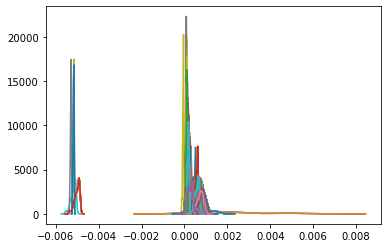

In [289]:
v_diff.plot.density()

In [290]:
v_diff.size

200256

In [291]:
arr = v_diff.values.copy()
arr.resize(1, v_diff.size)

<AxesSubplot:ylabel='Density'>

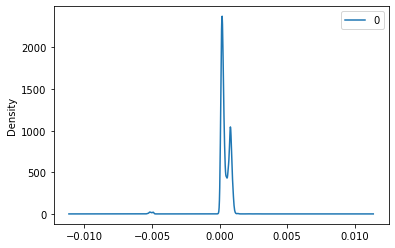

In [296]:
density = pd.DataFrame(arr.T)
density.plot.density()

In [304]:
density.min()

0   -0.005517
dtype: float64

In [305]:
density.max()

0    0.005746
dtype: float64

In [298]:
import seaborn as sns

<AxesSubplot:xlabel='0'>

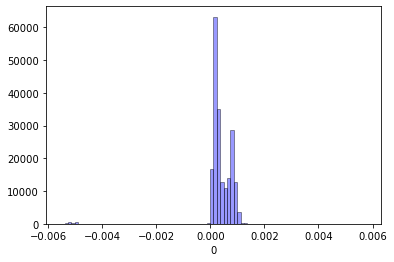

In [309]:
sns.distplot(density[0], hist=True, kde=False, 
             bins=int(90), color = 'blue',
             hist_kws={'edgecolor':'black'})

c:\users\aheider\.conda\envs\edisgo_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



<AxesSubplot:xlabel='0', ylabel='Density'>

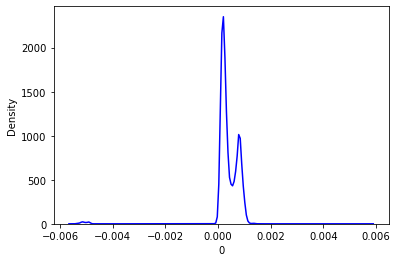

In [311]:
sns.distplot(density[0], hist=False, kde=True, 
             bins=int(90), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [312]:
density.index

RangeIndex(start=0, stop=200256, step=1)

<AxesSubplot:>

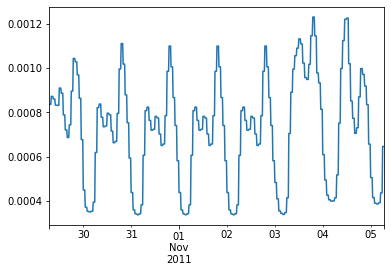

In [319]:
edisgo_obj.timeseries.loads_active_power.iloc[0:672,0].plot()

In [320]:
from edisgo import EDisGo

In [334]:
edisgo_obj = EDisGo(ding0_grid = r'U:\Software\elia_ding0_grids\2534', timeseries_generation_fluctuating='oedb', timeseries_load='demandlib')

Importing PyPSA from older version of PyPSA than current version 0.17.1.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network 2534 has buses, generators, lines, loads, transformers


In [324]:
#edisgo_obj.timeseries.from_csv(r'U:\Software\eDisGo_object_files\simbev_nep_2035_results\2534\reduced\timeseries')

In [333]:
edisgo_obj.topology.generators_df.type.unique()

array(['solar'], dtype=object)

<AxesSubplot:>

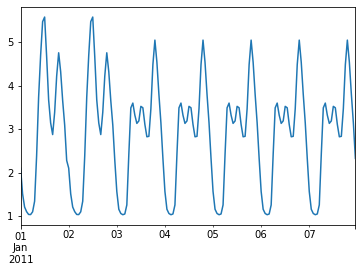

In [336]:
edisgo_obj.timeseries.loads_active_power[edisgo_obj.topology.loads_df.loc[edisgo_obj.topology.loads_df.sector=='residential'].index].sum(axis=1)[0:7*24].plot()

<AxesSubplot:>

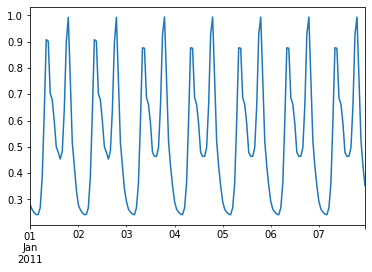

In [337]:
edisgo_obj.timeseries.loads_active_power[edisgo_obj.topology.loads_df.loc[edisgo_obj.topology.loads_df.sector=='agricultural'].index].sum(axis=1)[0:7*24].plot()

<AxesSubplot:>

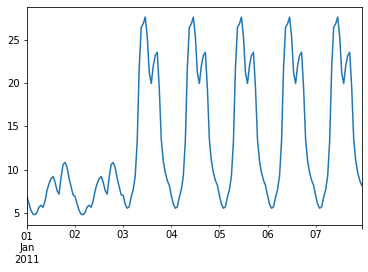

In [338]:
edisgo_obj.timeseries.loads_active_power[edisgo_obj.topology.loads_df.loc[edisgo_obj.topology.loads_df.sector=='retail'].index].sum(axis=1)[0:7*24].plot()

<AxesSubplot:>

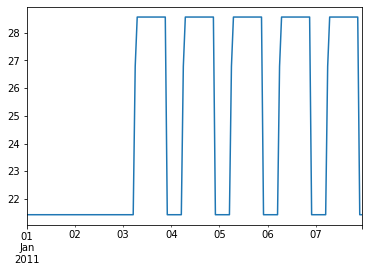

In [339]:
edisgo_obj.timeseries.loads_active_power[edisgo_obj.topology.loads_df.loc[edisgo_obj.topology.loads_df.sector=='industrial'].index].sum(axis=1)[0:7*24].plot()

In [340]:
edisgo_obj.topology.loads_df.loc[edisgo_obj.topology.loads_df.sector=='retail'].peak_load.sum()

29.093019970461846

In [341]:
edisgo_obj.topology.loads_df.loc[edisgo_obj.topology.loads_df.sector=='residential'].peak_load.sum()

5.758628904484363

In [342]:
edisgo_obj.topology.loads_df.loc[edisgo_obj.topology.loads_df.sector=='industrial'].peak_load.sum()

29.15876428838066

In [343]:
edisgo_obj.topology.loads_df.loc[edisgo_obj.topology.loads_df.sector=='agricultural'].peak_load.sum()

1.02771027719017

In [373]:
edisgo_obj.timeseries.loads_reactive_power

,Loads_Bus_mvgd_177_lvgd_408638_loa_1,Loads_Bus_mvgd_177_lvgd_408638_loa_2,Loads_Bus_mvgd_177_lvgd_408638_loa_3,Loads_Bus_mvgd_177_lvgd_408784_loa_1,Loads_Bus_mvgd_177_lvgd_408784_loa_2,Loads_Bus_mvgd_177_lvgd_408784_loa_3,Loads_Bus_mvgd_177_lvgd_408821_loa_1,Loads_Bus_mvgd_177_lvgd_408821_loa_2,Loads_Bus_mvgd_177_lvgd_408883_loa_1,Loads_Bus_mvgd_177_lvgd_408952_loa_1,...,Loads_Bus_mvgd_177_lvgd_50895_loa_10,Loads_Bus_mvgd_177_lvgd_50895_loa_11,Loads_Bus_mvgd_177_lvgd_50895_loa_2,Loads_Bus_mvgd_177_lvgd_50895_loa_3,Loads_Bus_mvgd_177_lvgd_50895_loa_4,Loads_Bus_mvgd_177_lvgd_50895_loa_5,Loads_Bus_mvgd_177_lvgd_50895_loa_6,Loads_Bus_mvgd_177_lvgd_50895_loa_7,Loads_Bus_mvgd_177_lvgd_50895_loa_8,Loads_Bus_mvgd_177_lvgd_50895_loa_9
2011-04-16 07:00:00,0.029083,0.029083,0.000349,0.034576,0.000209,0.000209,0.039459,0.000209,0.043304,0.043091,...,0.000237,0.000237,0.042847,0.027313,0.027313,0.027313,0.027313,0.000237,0.000237,0.000237
2011-04-16 07:15:00,0.029083,0.029083,0.000349,0.034576,0.000209,0.000209,0.039459,0.000209,0.043304,0.043091,...,0.000237,0.000237,0.042847,0.027313,0.027313,0.027313,0.027313,0.000237,0.000237,0.000237
2011-04-16 07:30:00,0.029083,0.029083,0.000349,0.034576,0.000209,0.000209,0.039459,0.000209,0.043304,0.043091,...,0.000237,0.000237,0.042847,0.027313,0.027313,0.027313,0.027313,0.000237,0.000237,0.000237
2011-04-16 07:45:00,0.029083,0.029083,0.000349,0.034576,0.000209,0.000209,0.039459,0.000209,0.043304,0.043091,...,0.000237,0.000237,0.042847,0.027313,0.027313,0.027313,0.027313,0.000237,0.000237,0.000237
2011-04-16 08:00:00,0.040741,0.040741,0.000370,0.048431,0.000222,0.000222,0.055267,0.000222,0.060638,0.060364,...,0.000251,0.000251,0.042847,0.038269,0.038269,0.038269,0.038269,0.000251,0.000251,0.000251
2011-04-16 08:15:00,0.040741,0.040741,0.000370,0.048431,0.000222,0.000222,0.055267,0.000222,0.060638,0.060364,...,0.000251,0.000251,0.042847,0.038269,0.038269,0.038269,0.038269,0.000251,0.000251,0.000251
2011-04-16 08:30:00,0.040741,0.040741,0.000370,0.048431,0.000222,0.000222,0.055267,0.000222,0.060638,0.060364,...,0.000251,0.000251,0.042847,0.038269,0.038269,0.038269,0.038269,0.000251,0.000251,0.000251
2011-04-16 08:45:00,0.040741,0.040741,0.000370,0.048431,0.000222,0.000222,0.055267,0.000222,0.060638,0.060364,...,0.000251,0.000251,0.042847,0.038269,0.038269,0.038269,0.038269,0.000251,0.000251,0.000251
2011-04-16 09:00:00,0.036865,0.036865,0.000366,0.043854,0.000219,0.000219,0.050018,0.000219,0.054901,0.054626,...,0.000249,0.000249,0.042847,0.034637,0.034637,0.034637,0.034637,0.000249,0.000249,0.000249
2011-04-16 09:15:00,0.036865,0.036865,0.000366,0.043854,0.000219,0.000219,0.050018,0.000219,0.054901,0.054626,...,0.000249,0.000249,0.042847,0.034637,0.034637,0.034637,0.034637,0.000249,0.000249,0.000249
